In [70]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LogisticRegression
import sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import graphviz
from scipy import stats
import pmdarima as pm
import warnings
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.noise import GaussianNoise
from keras.layers.advanced_activations import PReLU
from keras.utils import np_utils
import itertools
import xgboost as xgb
import dtreeviz

<a id="esercizio1"></a>
## Classificazione

L'Organizzazione mondiale della sanità ha stimato che 12 milioni di decessi si verificano in tutto il mondo, ogni anno a causa di malattie cardiache. La metà dei decessi negli Stati Uniti e in altri paesi sviluppati è dovuta a malattie cardiovascolari. La prognosi precoce delle malattie cardiovascolari può aiutare a prendere decisioni sui cambiamenti dello stile di vita nei pazienti ad alto rischio e, a sua volta, ridurre le complicanze.

Il dataset con i dati che useremo si trova nel filw `data/framingham.csv`. Il dataset contiene i seguenti dati:

Demografici:
- male: maschio o femmina (nominale)
- age: età del paziente (continua - Sebbene le età registrate siano state troncate a numeri interi, il concetto di età è continuo)

Comportamentali:
- currentSmoker: se il paziente sia o meno un fumatore attuale (nominale)
- cigsPerDay: il numero di sigarette che la persona ha fumato in media in un giorno (può essere considerato continuo in quanto si può avere un numero qualsiasi di sigarette, anche mezza sigaretta)

Storia medica:
- BPMeds: se il paziente assumeva o meno un farmaco per la pressione arteriosa (nominale)
- prevalentStroke: se il paziente ha avuto o meno un ictus (nominale)
- prevalentHyp: se il paziente è iperteso (nominale)
- diabetes: se il paziente ha o meno il diabete (nominale)

Situazione medica attuale:
- totChol: livello di colesterolo totale (continuo)
- sysBP: pressione arteriosa sistolica (continua)
- diaBP: pressione arteriosa diastolica (continua)
- BMI: indice di massa corporea (continuo)
- heartRate: frequenza cardiaca (continua - Nella ricerca medica, variabili come la frequenza cardiaca, sebbene in realtà discrete, sono comunque considerate continue a causa del gran numero di possibili valori)
- glucose: livello di glucosio (continuo)

Variabile che si vuole predire (target desiderato):
- TenYearCHD: Rischio di malattia coronarica nei prossimi 10 anni CHD (binario: '1' significa sì, '0' significa no)

### Imputazione dei missing values

Il dataset è acquisito e, come prima fase dell'analisi, uno studio dei valori mancanti è condotto. In tutto 645 istanze risultano mancanti, come mostrato nel grafico seguente; ognuna di queste è quindi risolta nel migliore dei modi, tenendo conto sia della natura della variabile mancante che della sua correlazione con le altri variabili nel dataset.

In [71]:
# acquisizione del dataset
df = pd.read_csv("./data/framingham.csv")
df

male  age  education  currentSmoker  cigsPerDay  BPMeds  \
0        1   39        4.0              0         0.0     0.0   
1        0   46        2.0              0         0.0     0.0   
2        1   48        1.0              1        20.0     0.0   
3        0   61        3.0              1        30.0     0.0   
4        0   46        3.0              1        23.0     0.0   
...    ...  ...        ...            ...         ...     ...   
4233     1   50        1.0              1         1.0     0.0   
4234     1   51        3.0              1        43.0     0.0   
4235     0   48        2.0              1        20.0     NaN   
4236     0   44        1.0              1        15.0     0.0   
4237     0   52        2.0              0         0.0     0.0   

      prevalentStroke  prevalentHyp  diabetes  totChol  sysBP  diaBP    BMI  \
0                   0             0         0    195.0  106.0   70.0  26.97   
1                   0             0         0    250.0  121.0   81.0  28.73   
2                   0             0         0    245.0  127.5   80.0  25.34   
3                   0             1         0    225.0  150.0   95.0  28.58   
4                   0             0         0    285.0  130.0   84.0  23.10   
...               ...           ...       ...      ...    ...    ...    ...   
4233                0             1         0    313.0  179.0   92.0  25.97   
4234                0             0         0    207.0  126.5   80.0  19.71   
4235                0             0         0    248.0  131.0   72.0  22.00   
4236                0             0         0    210.0  126.5   87.0  19.16   
4237                0             0         0    269.0  133.5   83.0  21.47   

      heartRate  glucose  TenYearCHD  
0          80.0     77.0           0  
1          95.0     76.0           0  
2          75.0     70.0           0  
3          65.0    103.0           1  
4          85.0     85.0           0  
...         ...      ...         ...  
4233       66.0     86.0           1  
4234       65.0     68.0           0  
4235       84.0     86.0           0  
4236       86.0      NaN           0  
4237       80.0    107.0           0  

[4238 rows x 16 columns]

In [72]:
# matrice di correlazione utile per l'eventuale correzione di missing values 
plt.figure(figsize=(10,10)) 
df_corr = df.loc[:,:]
corr = df_corr.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

<Figure size 720x720 with 0 Axes>

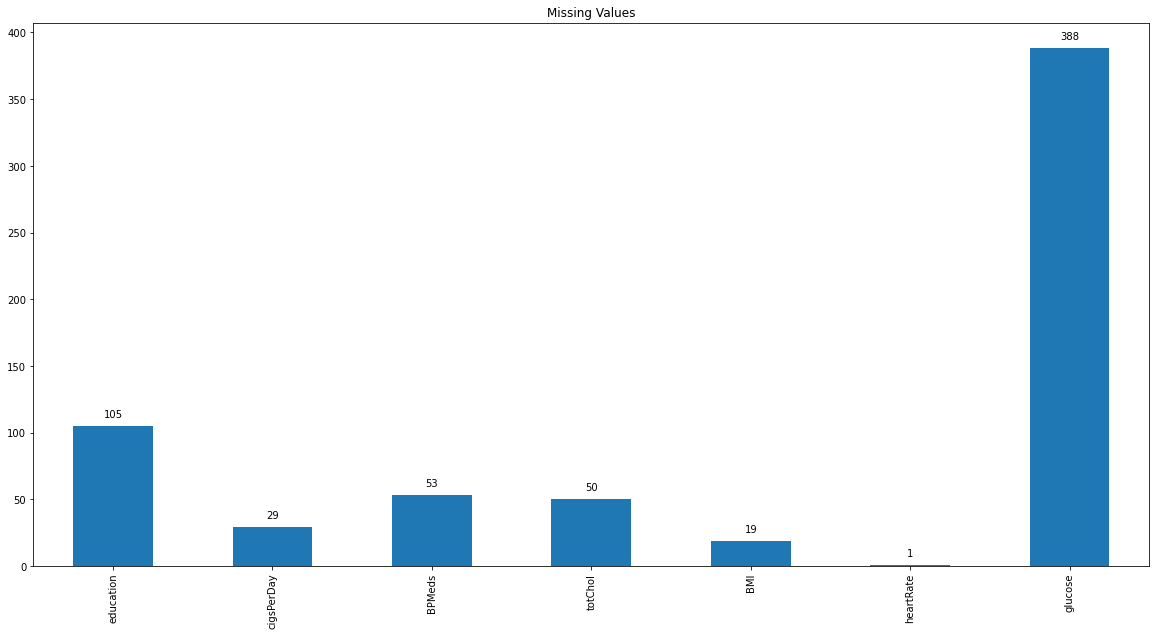

Total missing values: 645


In [73]:
# calcolo e visualizzazione dei valori mancanti

missing = df.isnull().sum()
missing = missing[missing !=0]

fig = plt.figure(figsize=(20,10))
ax = missing.plot.bar(x=missing)

for rect, label in zip( ax.patches, missing.values):
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width() / 2, height + 5, label, ha="center", va="bottom"
    )
ax.set_title('Missing Values')
plt.show()

print(f'Total missing values: {missing.sum()}')

#### Cigarettes per day

Data l'alta correlazione tra le sigarette fumate giornalmente e il genere dell'individuo è ipotizzata una possibile differenza tra la media di sigarette fumate da un uomo e quelle fumate da una donna. Questa teoria è confermata da uno statistica test effettuato sui due valori che, a riguardo, restituisce esito positivo. Dati questi presupposti l'imputazione dei missing values per questa variabile avviene prendendo la media delle sigarette fumate dal genere di apparteneza di ogni individuo a cui il valore mancante appartiene. 

In [74]:
# studio se vi è una differenza nel numero di sigarette fumate tra i due generi

male = df[df['male'] == 1].cigsPerDay
female = df[df['male'] == 0].cigsPerDay

stats.ttest_ind(list(male), list(female), equal_var = False, nan_policy='omit') # vi è una differenza, non uso una media unica ma inputo i valori mancanti in base al gruppo di appartenenza

Ttest_indResult(statistic=20.530248845430364, pvalue=1.373552564895393e-87)

In [75]:
# media delle sigarette fumate per entrambi i generi
mean_male = male.mean()
mean_female = female.mean()
print(f'Media sigarette per uomo: {mean_male}')
print(f'Media sigarette per donna: {mean_female}')
print(f'Differenza tra le medie: {mean_male-mean_female}')

# imputazione valori amncanti
import warnings 
with warnings.catch_warnings():
    warnings.filterwarnings("ignore") # Warnings: A value is trying to be set on a copy of a slice from a DataFrame
    
    male[pd.isna(male)] = mean_male
    female[pd.isna(female)] = mean_female

new_cigs_day = female.append(male).sort_index(ascending=True)

Media sigarette per uomo: 13.37617728531856
Media sigarette per donna: 5.71963394342762
Differenza tra le medie: 7.65654334189094


In [76]:
# controllo se vi sono ancora valori mancanti
df.cigsPerDay = new_cigs_day
df['cigsPerDay'].isna().any() # valori mancanti risolti

False

#### Heart rate

Mancando una sola istanza è presa la mediana dei valori della variabile in esame.

In [77]:
# questo missing value è imputato come mediana dei valori per le altre osservazioni
heart_rate_median = df.heartRate.median()

missing = df[pd.isnull(df['heartRate'])].index
df.loc[missing, ['heartRate']] = heart_rate_median

df['heartRate'].isna().any() 

False

#### Education

Questa variabile si presenta come una categorica a 4 classi e, per imputare i valori mancanti, si è scelto di non stravolgere la proporzione delle istanze in ognuna di esse. Quindi, prima di tutto, è calcolata la percentuale di istanze presente in ogni classe per tutte le osservazioni del dataset e, poi, i valori mancanti sono ripartiti secondo la suddetta percentuale.

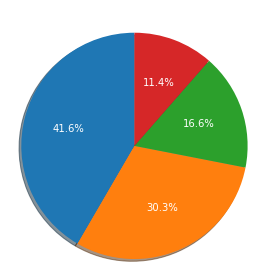

In [78]:
# percentuale delle osservazioni per ogni classe di questa variabile categorica
fig = plt.figure(figsize=(10,10)) 
ax2 = fig.add_subplot(2,2,2)
ax2.pie(df['education'].value_counts(), labels=['1', '2','3','4'], autopct='%1.1f%%',
        shadow=True, startangle=90, textprops={'color':"w"})
ax2.axis('equal')
ax2.set_title('Missing Values Education', color = 'white')
plt.show()

In [79]:
# i valori mancanti sono suddivisi e assegnati in base alle percentuali di cui sopra
missing = df['education'].isna().sum()
values = np.array([1, 2, 3, 4])
repeats = np.array([int(np.round(missing*0.41)), int(np.round(missing*0.11)), int(np.round(missing*0.17)), int(np.round(missing*0.31))])
subs = np.repeat(values, repeats)[1:]

In [80]:
# valori mancanti risolti
idx = df[df['education'].isna()].index
df.loc[idx, ['education']] = list(subs)
df['education'].isna().any() 

False

#### Glucose

Come per la variabile rappresentante le sigarette fumate in un giorno anche qui si è di fronte ad una significativa differenza tra i livelli di glucosio che un individuo diabetico registra e quelli per un individuo non diabetico. In modo similare i valori mancanti sono riempiti prendendo il livello medio di glucosio della categoria a cui l'individuo che riporta il missing value appartiene.

In [81]:
# avendo una forte correlazione con il diabete si controlla la differenza tra la media di glucosio della popolazione diabetica e quella che non lo è.
diabetes = df[df['diabetes'] == 1].glucose
no_diabetes = df[df['diabetes'] == 0].glucose

mean_diabetes = diabetes.mean()
mean_no_diabetes = no_diabetes.mean()

print(f'Livello di glucosio medio per paziente con diabete: {mean_diabetes}')
print(f'Livello di glucosio medio per paziente senza diabete: {mean_no_diabetes}')
print(f'Differenza tra le medie: {mean_diabetes-mean_no_diabetes}')

print(f"La differenza è statisticamente significativa: {stats.ttest_ind(list(diabetes), list(no_diabetes), equal_var = False, nan_policy='omit')}")

Livello di glucosio medio per paziente con diabete: 170.33333333333334
Livello di glucosio medio per paziente senza diabete: 79.48918558077436
Differenza tra le medie: 90.84414775255898
La differenza è statisticamente significativa: Ttest_indResult(statistic=11.047631144287996, pvalue=3.038311892042306e-19)


In [82]:
# risoluzione dei valori mancanti
with warnings.catch_warnings():
    warnings.filterwarnings("ignore") # Warnings: A value is trying to be set on a copy of a slice from a DataFrame
    
    diabetes[pd.isna(diabetes)] = mean_diabetes
    no_diabetes[pd.isna(no_diabetes)] = mean_no_diabetes

new_glucose = no_diabetes.append(diabetes).sort_index(ascending=True)

df.glucose = new_glucose
df['glucose'].isna().any() # valori mancanti risolti

False

#### Livello di colesterolo totale (totChol)

Il livello di colesterolo totale presenta una forte correlazione con l'età del paziente, per questo motivo le medie utilizzate per completare i valori mancanti sono calcolate in base a fasce di età di circa 5 anni l'una.

In [83]:
# l'età è correlata con questa variabile, la variabile età continua è discretizzata in fasce da 5 anni ciascuna
df['age_bins'] = pd.cut(df['age'], 8)
col_mean = df.groupby('age_bins').mean()['totChol']
col_mean

age_bins
(31.962, 36.75]    207.469799
(36.75, 41.5]      218.744737
(41.5, 46.25]      230.817967
(46.25, 51.0]      240.197497
(51.0, 55.75]      248.067857
(55.75, 60.5]      250.735945
(60.5, 65.25]      247.843818
(65.25, 70.0]      244.349057
Name: totChol, dtype: float64

In [84]:
# i valori mancanti sono risolti prendendo la media del colesterolo per la rispettiva fascia di età
idx = df[pd.isna(df.totChol)].index
for x in idx:
    i= 0
    while i in range(0,len(col_mean)):
        if (df.loc[x,['age_bins']].values == col_mean.index.values[i]):
            df.loc[x,['totChol']] = col_mean[i]
        i+=1

df['totChol'].isna().any()

False

#### Farmaco per la pressione arteriosa (BPMeds)

Lo scopo di trovare i valori mancanti per questa variabile binaria può essere raggiunto mediante un classificatore. In questo caso viene costruita una Support Vector Machine che, utilizzando come input le  variabili più correlate a quella in esame, restituisce una previsione dei valori che questa dovrebbe assumere.  
Di seguito la SVM è addestrata e le sue performance sono mostrate e commentate.

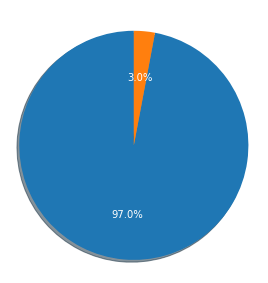

In [85]:
# sudivisione tra chi prende il farmaco per la pressione arteriosa e chi no
fig = plt.figure(figsize=(10,10)) 
ax2 = fig.add_subplot(2,2,2)
ax2.pie(df['BPMeds'].value_counts(), labels=['0', '1'], autopct='%1.1f%%',
        shadow=True, startangle=90, textprops={'color':"w"})
ax2.axis('equal')
ax2.set_title('BPMeds', color = 'white')
plt.show()

In [86]:
# suddivisione del dataset in due subset, uno con solo i missing values e uno senza
df1 = df[pd.notna(df.BPMeds)] # senza missing values (per l'addestramento del classificatore)
df2 = df[pd.isna(df.BPMeds)] # solo con missing values (per la loro imputazione)

# selezione delle variabili più correlate con quella di riferimento
variables = ['prevalentHyp', 'sysBP', 'diaBP', 'age', 'prevalentStroke']
y_df1 = df1['BPMeds']
x_df1 = df1[variables]

In [87]:
from sklearn.model_selection import train_test_split
# split tra dataset di train e di test
x_train, x_test, y_train, y_test = train_test_split(x_df1, y_df1, test_size=0.2) # partizionamento al 20%

In [88]:
import sklearn
from imblearn.over_sampling import RandomOverSampler

# data la natura completamente sbilanciata della variabile target si utilizza un algoritmo di oversample
oversample = RandomOverSampler(sampling_strategy=0.3) # oversample fino a portare la classe positiva al 30% del training set 
x_over, y_over = oversample.fit_resample(x_train, y_train)

In [89]:
from sklearn.svm import SVC

# creazione e fitting di una SVM come classificatore
svc = SVC(random_state=0, probability=True)
svc.fit(x_over, y_over)

# previsioni sul test set
y_pred = svc.predict(x_test)
proba_svc = svc.predict_proba(x_test)

In [90]:
from sklearn.metrics import classification_report, confusion_matrix

# classification report dei risultati della previsione
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.99      0.94      0.96       817
         1.0       0.17      0.50      0.25        20

    accuracy                           0.93       837
   macro avg       0.58      0.72      0.61       837
weighted avg       0.97      0.93      0.95       837



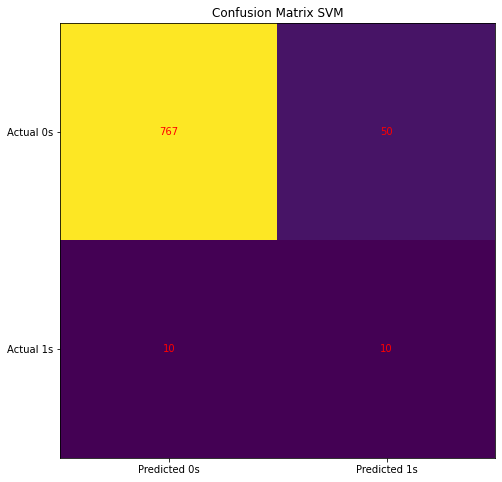

In [91]:
# matrice di confusione per il modello 
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.title("Confusion Matrix SVM")
plt.show()

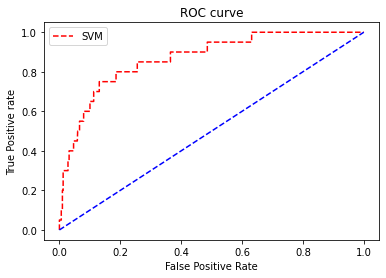

SVC AUC: 0.869


In [92]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

# creazione della curva ROC per i modelli 
fpr1, tpr1, thresh1 = roc_curve(y_test, proba_svc[:,1], pos_label=1)

# roc per il classificatore casuale
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

# plot roc
plt.plot(fpr1, tpr1, linestyle='--',color='red', label='SVM')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.show()

# auc
roc_auc_svc = auc(fpr1, tpr1)
print(f'SVC AUC: {roc_auc_svc:.3f}')

In generale le performance di questo classificatore non sono entusiasmanti, esso compie un buon lavoro nel trovare i veri negativi, ma, cerare di alzare il suo grado di precisione nella classificazione di veri positivi, alza inevitabilmente anche il numero di falsi positivi risultanti.  
Dato il numero basso di pazienti che assumono un farmaco per la pressione arteriosa nel dataset si preferisce favorire una classificazione più spinta verso questo senso piuttosto di introdurre troppi falsi positivi che potrebbero alterare la natura della variabile in esame. Ad ogni modo, come mostrato dalla curva ROC, questo classificatore è comunque meglio rispetto ad un'allocazione casuiale dei valori mancanti.

In [93]:
# utilizzo della SVM creata per prevedere la classe dei valori mancanti
x = df2[variables]
pred = svc.predict(x)

# imputazione dei missing values
idx = df[df['BPMeds'].isna()].index
df.loc[idx, ['BPMeds']] = list(pred)
df['BPMeds'].isna().any() 

False

#### BMI

Questa variabile è correlata a due altri predittori continui e due binari. Un'analisi della relazione con i primi dimostra come non vi sia un particolare pattern di distribuzione da poter utilizzare per una facile predizione del valore di interesse. La scelta ricade quindi sul calcolo di medie condizionate dalle due variabili binarie per determinare i valori da utilizzare per risolvere i missing values di ogni individuo.  
In particolare si nota come la media dell'indice BMI per i pazienti ipertesi sia significativamente più alta rispetto a quella dei pazienti non ipertesi e, che, a parità di questa condizione, vi sia una differenza tra le medie delle varie fasce di età. Ogni valore mancante è quindi imputato in base all'età e alla condizione di ipertensione o meno di cui gode il paziente.

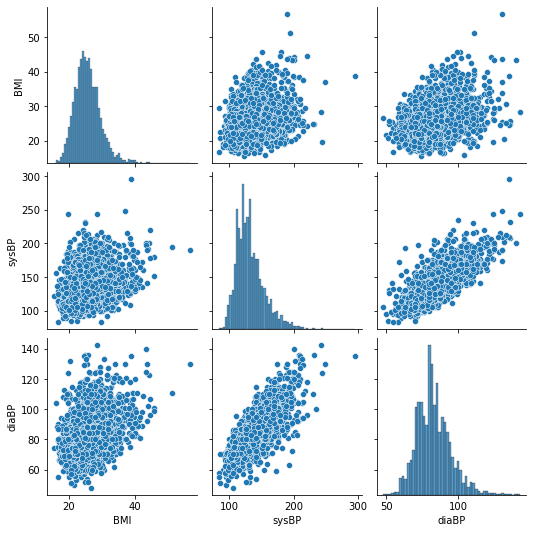

In [94]:
# pairplot tra BMI e le variabili con la più alta correlazione
ax = sns.pairplot(df[['BMI', 'sysBP', 'diaBP']])
plt.show() # non ho correlazione lineare tra BMI e le altre variabili

In [95]:
# calcolo differenza tra la media del BMI di chi è iperteso e chi non lo è
hyp = df[df['prevalentHyp'] == 1].BMI
no_hyp = df[df['prevalentHyp'] == 0].BMI

print(f'BMI medio per paziente iperteso: {hyp.mean()}')
print(f'BMI medio per paziente non iperteso: {no_hyp.mean()}')
print(f'Differenza tra le medie: {hyp.mean()-no_hyp.mean()}')

print(f"La differenza è statisticamente significativa: {stats.ttest_ind(list(hyp), list(no_hyp), equal_var = False, nan_policy='omit')}")

BMI medio per paziente iperteso: 27.63483575248281
BMI medio per paziente non iperteso: 24.97754982817865
Differenza tra le medie: 2.657285924304162
La differenza è statisticamente significativa: Ttest_indResult(statistic=18.636811242177558, pvalue=1.0517693699199976e-71)


In [96]:
# creazione di un dataset di sole persone ipertese e uno di sole persone non ipertese
df_1 = df[df['prevalentHyp'] == 1]
df_0 = df[df['prevalentHyp'] == 0]

# media per fasce di età nei due rispettivi dataframes
age_mean_1 = df_1.groupby('age_bins').mean()['BMI']
age_mean_0 = df_0.groupby('age_bins').mean()['BMI']

print(f'Media BMI per pazienti ipertesi: {age_mean_1}')
print(f'Media per pazienti non ipertesi: {age_mean_0}')

Media BMI per pazienti ipertesi: age_bins
(31.962, 36.75]    27.622353
(36.75, 41.5]      28.573302
(41.5, 46.25]      28.081285
(46.25, 51.0]      27.158288
(51.0, 55.75]      27.513333
(55.75, 60.5]      27.351603
(60.5, 65.25]      27.721750
(65.25, 70.0]      27.718286
Name: BMI, dtype: float64
Media per pazienti non ipertesi: age_bins
(31.962, 36.75]    24.187879
(36.75, 41.5]      24.634598
(41.5, 46.25]      24.746637
(46.25, 51.0]      24.928777
(51.0, 55.75]      25.636182
(55.75, 60.5]      25.524333
(60.5, 65.25]      25.419641
(65.25, 70.0]      24.958205
Name: BMI, dtype: float64


In [97]:
# imputazione missing values in base alla presenza di ipetensione e alla fascia di età di appartenenza 
idx_1 = df_1[pd.isna(df_1.BMI)].index
for x in idx_1:
    i= 0
    while i in range(0,len(age_mean_1)):
        if (df.loc[x,['age_bins']].values == age_mean_1.index.values[i]):
            df.loc[x,['BMI']] = age_mean_1[i]
        i+=1
        
idx_0 = df_0[pd.isna(df_0.BMI)].index
for x in idx_0:
    i= 0
    while i in range(0,len(age_mean_1)):
        if (df.loc[x,['age_bins']].values == age_mean_1.index.values[i]):
            df.loc[x,['BMI']] = age_mean_1[i]
        i+=1
        
# controllo buona riuscita per l'imputazione dei missing values       
df.BMI.isna().any()

False

### Descrizione del dataset

#### Variabili demografiche 

* Age
* Gender

In [63]:
freq_male = df.male.value_counts()
xaxis = freq_male.index
value_male = freq_male.values

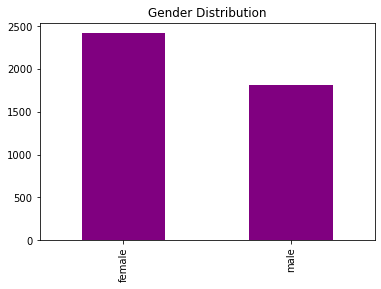

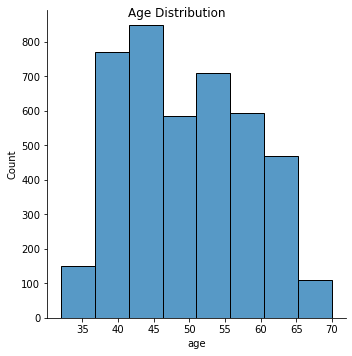

In [575]:
# distribuzione delle osservazioni per gender 
fig = plt.figure() 
fig = freq_male.plot.bar(value_male, color='purple')
fig.set_xticklabels(['female', 'male'])
fig.set_title('Gender Distribution')

# distribuzione delle osservazioni per età
fig1 = sns.displot(df.age, bins=8, kde = False) #circa 5 anni x facsia di eta
fig1.fig.suptitle('Age Distribution')

plt.show()

In [522]:
# calcolo di diverse metriche per la variabile continua 

mean = df.age.mean()
print("Age's mean:", round(mean,2))
print("-----------------------------")

median = df.age.median()
print("Age's median:", round(median,2))

print("-----------------------------")
age_sort = df.age.sort_values()
age_sort = age_sort.reset_index(drop = True)
limit = 0.1
limits = (age_sort[round(df.age.shape[0]*limit)], age_sort[round(df.age.shape[0]*(1-limit))])
trimmed_mean = stats.tmean(age_sort, limits=limits)
print("Age's trimmed mean:", round(trimmed_mean,2), "with the following limits:", limits)

print("-----------------------------")

variance = df.age.var()
print("Age's variance:", round(variance,2))
print("-----------------------------")

st_dev = df.age.std()
print("Age's standard deviation:", round(st_dev,2))
print("-----------------------------")

mean_absolute_deviation = df.age.mad()
print("Age's mean absolute deviation:", round(mean_absolute_deviation,2))
print("-----------------------------")

Age's mean: 49.58
-----------------------------
Age's median: 49.0
-----------------------------
Age's trimmed mean: 49.4 with the following limits: (39, 62)
-----------------------------
Age's variance: 73.48
-----------------------------
Age's standard deviation: 8.57
-----------------------------
Age's mean absolute deviation: 7.33
-----------------------------


**Gender** = Presenta una distribuzione quasi paritaria tra maschie e femmine, con una leggera prevalenza di queste ultime

**Age** = La distribuzione di questa variabile è normale e adeguatamente centrata, non si registra la presenza di alcun outlier significativo

#### Variabili comportamentali

* Current Smoker
* Cigarettes per Day

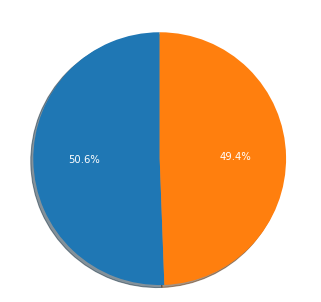

In [343]:
# suddivisione tra fumatori e non fumatori nel dataset
freq_smoker = df.currentSmoker.value_counts()
value_smoker = freq_smoker.values

fig, ax = plt.subplots(figsize=(5,5)) 
ax.pie(value_smoker, labels=['No', 'Yes'], autopct='%1.1f%%',
        shadow=True, startangle=90, textprops={'color':"w"})
ax.axis('equal')
ax.set_title('Current Smoker', color = 'white')
plt.show()

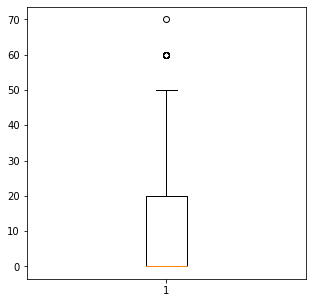

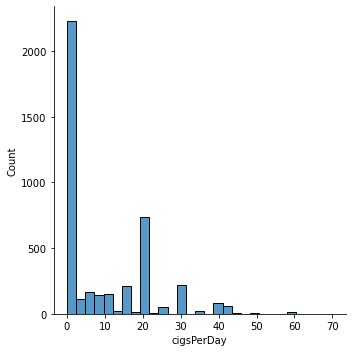

In [344]:
# boxplot e rappresentazione ad istogrammi per la variabile continua
fig, ax = plt.subplots(figsize=(5, 5))
ax.boxplot(df.cigsPerDay)
sns.displot(df.cigsPerDay, kde = False)
plt.show()

In [345]:
# calcolo di diverse metriche per la variabile continua 

mean = df.cigsPerDay.mean()
print("Cigarettes per day's mean:", round(mean,2))
print("-----------------------------")

median = df.cigsPerDay.median()
print("Cigarettes per day's median:", round(median,2))

print("-----------------------------")
sort = df.cigsPerDay.sort_values()
sort = sort.reset_index(drop = True)
limit = 0.1
limits = (sort[round(df.cigsPerDay.shape[0]*limit)], sort[round(df.cigsPerDay.shape[0]*(1-limit))])
trimmed_mean = stats.tmean(sort, limits=limits)
print("Cigarettes per day's trimmed mean:", round(trimmed_mean,2), "with the following limits:", limits)

print("-----------------------------")

variance = df.cigsPerDay.var()
print("Cigarettes per day's variance:", round(variance,2))
print("-----------------------------")

st_dev = df.cigsPerDay.std()
print("Cigarettes per day's standard deviation:", round(st_dev,2))
print("-----------------------------")

mean_absolute_deviation = df.cigsPerDay.mad()
print("Cigarettes per day's mean absolute deviation:", round(mean_absolute_deviation,2))
print("-----------------------------")

Cigarettes per day's mean: 9.01
-----------------------------
Cigarettes per day's median: 0.0
-----------------------------
Cigarettes per day's trimmed mean: 6.26 with the following limits: (0.0, 25.0)
-----------------------------
Cigarettes per day's variance: 141.22
-----------------------------
Cigarettes per day's standard deviation: 11.88
-----------------------------
Cigarettes per day's mean absolute deviation: 10.02
-----------------------------


**Current Smoker** = Distribuzione quasi perfettamente bilanciata

**Cigarettes per Day** = Distribuzione sbilanciata con coda a destra, infatti la maggior parte delle persone fumano 0 o poche sigarette al giorno. Inoltre l'analisi degli outliers evidenzia come il 75% delle osservazioni registri tra le 0 e le 10 sigarette fumate, mentre solo pochi valori superano questa soglia, toccando anche le 70 al giorno. Non essendo questo un numero umanamente impossibile si è deciso di lasciare comunque queste osservazione nel dataset e di considerarle valide.

#### Storia medica:

* BPMeds: se il paziente assumeva o meno un farmaco per la pressione arteriosa
* prevalentStroke: se il paziente ha avuto o meno un ictus
* prevalentHyp: se il paziente è iperteso
* diabetes: se il paziente ha o meno il diabete

In [346]:
freq_meds = df.BPMeds.value_counts()
value_meds = freq_meds.values

freq_stroke = df.prevalentStroke.value_counts()
value_stroke = freq_stroke.values

freq_hyp = df.prevalentHyp.value_counts()
value_hyp = freq_hyp.values

freq_diabetes = df.diabetes.value_counts()
value_diabetes = freq_diabetes.values

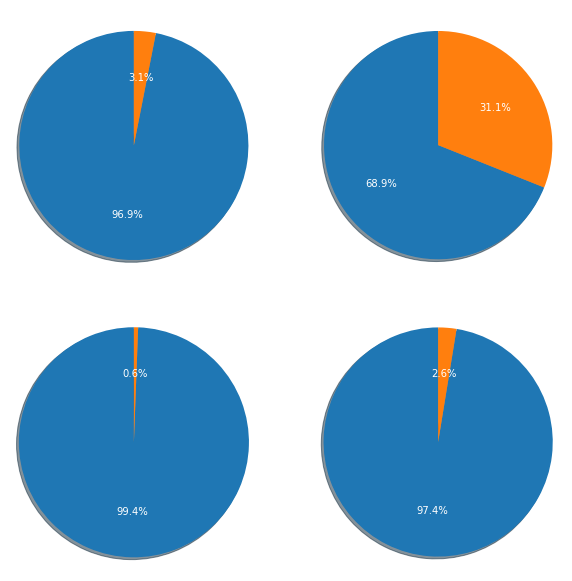

In [347]:
# rappresentazione delle distribuzioni per le seguenti variabili binarie

fig = plt.figure(figsize=(10,10))

ax1 = fig.add_subplot(2,2,1)
ax1.pie(value_meds, labels=['No', 'Yes'], autopct='%1.1f%%',
        shadow=True, startangle=90, textprops={'color':"w"})
ax1.axis('equal')
ax1.set_title('Assunzione farmaco pressione arteriosa', color = 'white')

ax2 = fig.add_subplot(2,2,2)
ax2.pie(value_hyp, labels=['No', 'Yes'], autopct='%1.1f%%',
        shadow=True, startangle=90, textprops={'color':"w"})
ax2.axis('equal')
ax2.set_title('Ipertensione', color = 'white')

ax3 = fig.add_subplot(2,2,3)
ax3.pie(value_stroke, labels=['No', 'Yes'], autopct='%1.1f%%',
        shadow=True, startangle=90, textprops={'color':"w"})
ax3.axis('equal')
ax3.set_title('Ha avuto un ictus?', color = 'white')

ax4 = fig.add_subplot(2,2,4)
ax4.pie(value_diabetes, labels=['No', 'Yes'], autopct='%1.1f%%',
        shadow=True, startangle=90, textprops={'color':"w"})
ax4.axis('equal')
ax4.set_title('Diabete', color = 'white')

plt.show()

Tutte queste variabili sono altamente sbilanciate verso l'assenza della condizione in esame, la meno sbilanciata risulta essere quella che funge da indicatore di ipertensione che, comunque, registra un valore negativo per i due terzi dei pazienti.

#### Situazione medica attuale

* totChol: livello di colesterolo totale
* sysBP: pressione arteriosa sistolica
* diaBP: pressione arteriosa diastolica
* BMI: indice di massa corporea 
* heartRate: frequenza cardiaca 
* glucose: livello di glucosio

Livello di colesterolo totale

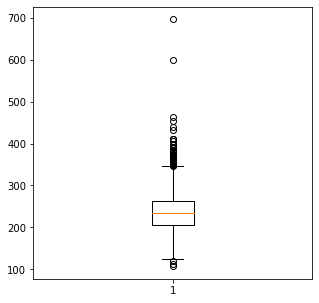

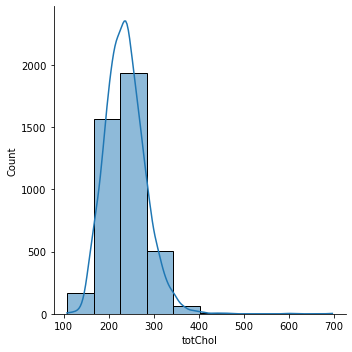

In [348]:
# boxplot e rappresentazione ad istogrammi per la variabile continua
fig, ax = plt.subplots(figsize=(5, 5))
ax.boxplot(df.totChol)
sns.displot(df.totChol, bins=10, kde = True)
plt.show()

In [349]:
# calcolo di diverse metriche per la variabile continua

mean = df.totChol.mean()
print("Total colesterol's mean:", round(mean,2))
print("-----------------------------")

median = df.totChol.median()
print("Total colesterol's median:", round(median,2))

print("-----------------------------")
sort = df.totChol.sort_values()
sort = sort.reset_index(drop = True)
limit = 0.1
limits = (sort[round(df.totChol.shape[0]*limit)], sort[round(df.totChol.shape[0]*(1-limit))])
trimmed_mean = stats.tmean(sort, limits=limits)
print("Total colesterol's trimmed mean:", round(trimmed_mean,2), "with the following limits:", limits)

print("-----------------------------")

variance = df.totChol.var()
print("Total colesterol's variance:", round(variance,2))
print("-----------------------------")

st_dev = df.totChol.std()
print("Total colesterol's standard deviation:", round(st_dev,2))
print("-----------------------------")

mean_absolute_deviation = df.totChol.mad()
print("Total colesterol's mean absolute deviation:", round(mean_absolute_deviation,2))
print("-----------------------------")

Total colesterol's mean: 236.74
-----------------------------
Total colesterol's median: 234.0
-----------------------------
Total colesterol's trimmed mean: 234.79 with the following limits: (184.0, 292.0)
-----------------------------
Total colesterol's variance: 1966.58
-----------------------------
Total colesterol's standard deviation: 44.35
-----------------------------
Total colesterol's mean absolute deviation: 34.29
-----------------------------


Pressione arteriosa sistolica

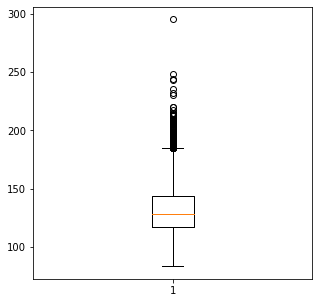

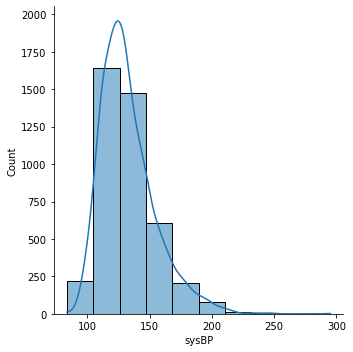

In [350]:
# boxplot e rappresentazione ad istogrammi per la variabile continua
fig, ax = plt.subplots(figsize=(5, 5))
ax.boxplot(df.sysBP)
sns.displot(df.sysBP, bins=10, kde = True)
plt.show()

In [351]:
# calcolo di diverse metriche per la variabile continua

mean = df.sysBP.mean()
print("Systolic pressure's mean:", round(mean,2))
print("-----------------------------")

median = df.sysBP.median()
print("Systolic pressure's median:", round(median,2))

print("-----------------------------")
sort = df.sysBP.sort_values()
sort = sort.reset_index(drop = True)
limit = 0.1
limits = (sort[round(df.sysBP.shape[0]*limit)], sort[round(df.sysBP.shape[0]*(1-limit))])
trimmed_mean = stats.tmean(sort, limits=limits)
print("Systolic pressure's trimmed mean:", round(trimmed_mean,2), "with the following limits:", limits)

print("-----------------------------")

variance = df.sysBP.var()
print("Systolic pressure's variance:", round(variance,2))
print("-----------------------------")

st_dev = df.sysBP.std()
print("Systolic pressure's standard deviation:", round(st_dev,2))
print("-----------------------------")

mean_absolute_deviation = df.sysBP.mad()
print("Systolic pressure's mean absolute deviation:", round(mean_absolute_deviation,2))
print("-----------------------------")

Systolic pressure's mean: 132.35
-----------------------------
Systolic pressure's median: 128.0
-----------------------------
Systolic pressure's trimmed mean: 130.14 with the following limits: (109.0, 162.0)
-----------------------------
Systolic pressure's variance: 485.68
-----------------------------
Systolic pressure's standard deviation: 22.04
-----------------------------
Systolic pressure's mean absolute deviation: 16.87
-----------------------------


Pressione arteriosa diastolica

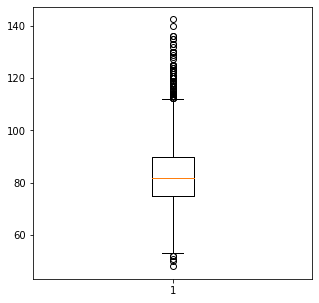

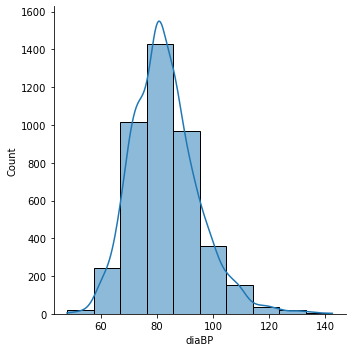

In [352]:
# boxplot e rappresentazione ad istogrammi per la variabile continua
fig, ax = plt.subplots(figsize=(5, 5))
ax.boxplot(df.diaBP)
sns.displot(df.diaBP, bins=10, kde = True)
plt.show()

In [353]:
# calcolo di diverse metriche per la variabile continua

mean = df.diaBP.mean()
print("Diastolic pressure's mean:", round(mean,2))
print("-----------------------------")

median = df.diaBP.median()
print("Diastolic pressure's median:", round(median,2))

print("-----------------------------")
sort = df.diaBP.sort_values()
sort = sort.reset_index(drop = True)
limit = 0.1
limits = (sort[round(df.diaBP.shape[0]*limit)], sort[round(df.diaBP.shape[0]*(1-limit))])
trimmed_mean = stats.tmean(sort, limits=limits)
print("Diastolic pressure's trimmed mean:", round(trimmed_mean,2), "with the following limits:", limits)

print("-----------------------------")

variance = df.diaBP.var()
print("Diastolic pressure's variance:", round(variance,2))
print("-----------------------------")

st_dev = df.diaBP.std()
print("Diastolic pressure's standard deviation:", round(st_dev,2))
print("-----------------------------")

mean_absolute_deviation = df.diaBP.mad()
print("Diastolic pressure's mean absolute deviation:", round(mean_absolute_deviation,2))
print("-----------------------------")

Diastolic pressure's mean: 82.89
-----------------------------
Diastolic pressure's median: 82.0
-----------------------------
Diastolic pressure's trimmed mean: 82.12 with the following limits: (69.0, 98.0)
-----------------------------
Diastolic pressure's variance: 141.87
-----------------------------
Diastolic pressure's standard deviation: 11.91
-----------------------------
Diastolic pressure's mean absolute deviation: 9.15
-----------------------------


Indice di massa corporea

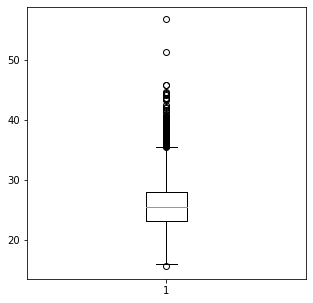

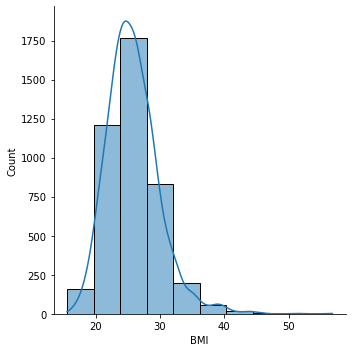

In [354]:
# boxplot e rappresentazione ad istogrammi per la variabile continua
fig, ax = plt.subplots(figsize=(5, 5))
ax.boxplot(df.BMI)
sns.displot(df.BMI, bins=10, kde = True)
plt.show()

In [355]:
# calcolo di diverse metriche per la variabile continua

mean = df.BMI.mean()
print("Body Mass Index's mean:", round(mean,2))
print("-----------------------------")

median = df.BMI.median()
print("Body Mass Index's median:", round(median,2))

print("-----------------------------")
sort = df.BMI.sort_values()
sort = sort.reset_index(drop = True)
limit = 0.1
limits = (sort[round(df.BMI.shape[0]*limit)], sort[round(df.BMI.shape[0]*(1-limit))])
trimmed_mean = stats.tmean(sort, limits=limits)
print("Body Mass Index's trimmed mean:", round(trimmed_mean,2), "with the following limits:", limits)

print("-----------------------------")

variance = df.BMI.var()
print("Body Mass Index's variance:", round(variance,2))
print("-----------------------------")

st_dev = df.BMI.std()
print("Body Mass Index's standard deviation:", round(st_dev,2))
print("-----------------------------")

mean_absolute_deviation = df.BMI.mad()
print("Body Mass Index's mean absolute deviation:", round(mean_absolute_deviation,2))
print("-----------------------------")

Body Mass Index's mean: 25.81
-----------------------------
Body Mass Index's median: 25.41
-----------------------------
Body Mass Index's trimmed mean: 25.55 with the following limits: (21.1, 30.77)
-----------------------------
Body Mass Index's variance: 16.59
-----------------------------
Body Mass Index's standard deviation: 4.07
-----------------------------
Body Mass Index's mean absolute deviation: 3.1
-----------------------------


Frequenza cardiaca

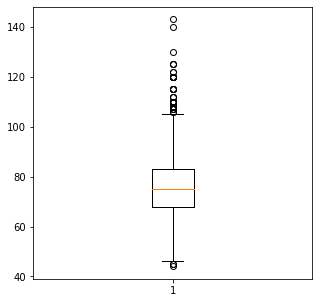

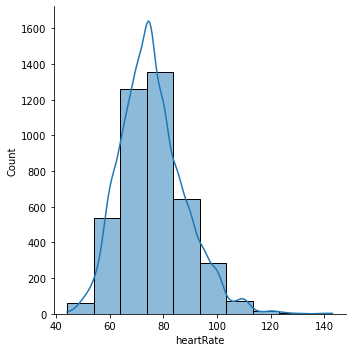

In [356]:
# boxplot e rappresentazione ad istogrammi per la variabile continua
fig, ax = plt.subplots(figsize=(5, 5))
ax.boxplot(df.heartRate)
sns.displot(df.heartRate, bins=10, kde = True)
plt.show()

In [357]:
# calcolo di diverse metriche per la variabile continua

mean = df.heartRate.mean()
print("Heart rate's mean:", round(mean,2))
print("-----------------------------")

median = df.heartRate.median()
print("Heart rate's median:", round(median,2))

print("-----------------------------")
sort = df.heartRate.sort_values()
sort = sort.reset_index(drop = True)
limit = 0.1
limits = (sort[round(df.heartRate.shape[0]*limit)], sort[round(df.heartRate.shape[0]*(1-limit))])
trimmed_mean = stats.tmean(sort, limits=limits)
print("Heart rate's trimmed mean:", round(trimmed_mean,2), "with the following limits:", limits)

print("-----------------------------")

variance = df.heartRate.var()
print("Heart rate's variance:", round(variance,2))
print("-----------------------------")

st_dev = df.heartRate.std()
print("Heart rate's standard deviation:", round(st_dev,2))
print("-----------------------------")

mean_absolute_deviation = df.heartRate.mad()
print("Heart rate's mean absolute deviation:", round(mean_absolute_deviation,2))
print("-----------------------------")

Heart rate's mean: 75.88
-----------------------------
Heart rate's median: 75.0
-----------------------------
Heart rate's trimmed mean: 74.46 with the following limits: (60.0, 92.0)
-----------------------------
Heart rate's variance: 144.61
-----------------------------
Heart rate's standard deviation: 12.03
-----------------------------
Heart rate's mean absolute deviation: 9.31
-----------------------------


Livello di glucosio

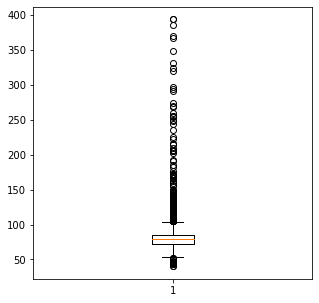

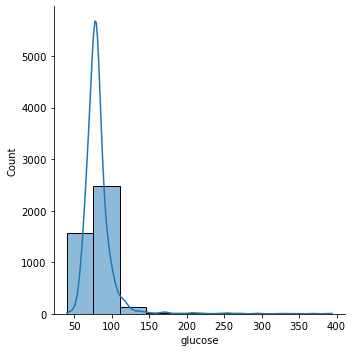

In [358]:
# boxplot e rappresentazione ad istogrammi per la variabile continua
fig, ax = plt.subplots(figsize=(5, 5))
ax.boxplot(df.glucose)
sns.displot(df.glucose, bins=10, kde = True)
plt.show()

In [359]:
# calcolo di diverse metriche per la variabile continua

mean = df.glucose.mean()
print("Glucose's mean:", round(mean,2))
print("-----------------------------")

median = df.glucose.median()
print("Glucose's median:", round(median,2))

print("-----------------------------")
sort = df.glucose.sort_values()
sort = sort.reset_index(drop = True)
limit = 0.1
limits = (sort[round(df.glucose.shape[0]*limit)], sort[round(df.glucose.shape[0]*(1-limit))])
trimmed_mean = stats.tmean(sort, limits=limits)
print("Glucose's trimmed mean:", round(trimmed_mean,2), "with the following limits:", limits)

print("-----------------------------")

variance = df.glucose.var()
print("Glucose's variance:", round(variance,2))
print("-----------------------------")

st_dev = df.glucose.std()
print("Glucose's standard deviation:", round(st_dev,2))
print("-----------------------------")

mean_absolute_deviation = df.glucose.mad()
print("Glucose's mean absolute deviation:", round(mean_absolute_deviation,2))
print("-----------------------------")

Glucose's mean: 81.83
-----------------------------
Glucose's median: 79.49
-----------------------------
Glucose's trimmed mean: 79.06 with the following limits: (66.0, 97.0)
-----------------------------
Glucose's variance: 529.42
-----------------------------
Glucose's standard deviation: 23.01
-----------------------------
Glucose's mean absolute deviation: 11.58
-----------------------------


Tutti i predittori considerati in questo ultimo blocco presentano un comportamento molto simile tra loro. In generale si può osservare come siano tutti caratterizzati da una distribuzione tendenzialmente normale che possiede, però, la presenza di una leggera coda a destra, inoltre tutte le variabili presentano outlier più pronunciati per i valori alti, responsabili della coda di cui sopra. Gli outliers risultano comunque credibili e, quindi, sono lasciati all'interno del dataset e considerati come valori attendibili da utilizzare per le previsioni.

#### Variabile Target

Rischio di malattia coronarica nei prossimi 10 anni

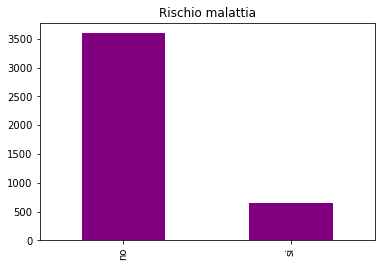

In [360]:
# distribuzione della variabile target
freq_chd = df.TenYearCHD.value_counts()
value_chd = freq_chd.values

fig = plt.figure() 
fig = freq_chd.plot.bar(value_chd, color='purple')
fig.set_xticklabels(['no', 'si'])
fig.set_title('Rischio malattia')
plt.show()

La variabile target risulta particolarmente sbilanciata verso l'assenza di rischio per la malattia in esame.

### Studio della correlazione

La correlazione è analizzata partendo da una tabella che evidenzia l'intensità del fenomeno per le varie coppie di variabili nel dataset. In generale, salvo qualche ovvia eccezione, non saltano all'occhio spiccate correlazioni tra le variabili e, in particolare, la variabile target risulta possedere correlazioni abbastanza basse con tutti gli altri predittori che, in ogni caso, non hanno mai valori superiori allo 0.23.  

La correlazione tra le variabili continue è ulteriormente analizzata attraverso un *pairplot*; tra tutte solo *sysBP* e *diaBP* sembrano possedere un interessante pattern lineare che le lega.

Infine l'evoluzione del colesterolo e della pressione sistolica per fasce di età è mostrata attraverso la realizzazione di un paio di *violin plots*.

In [693]:
# tabella di correlazione per le variabili nel dataset
plt.figure(figsize=(10,10)) 
df_corr = df.loc[:,:]
corr = df_corr.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

<Figure size 720x720 with 0 Axes>

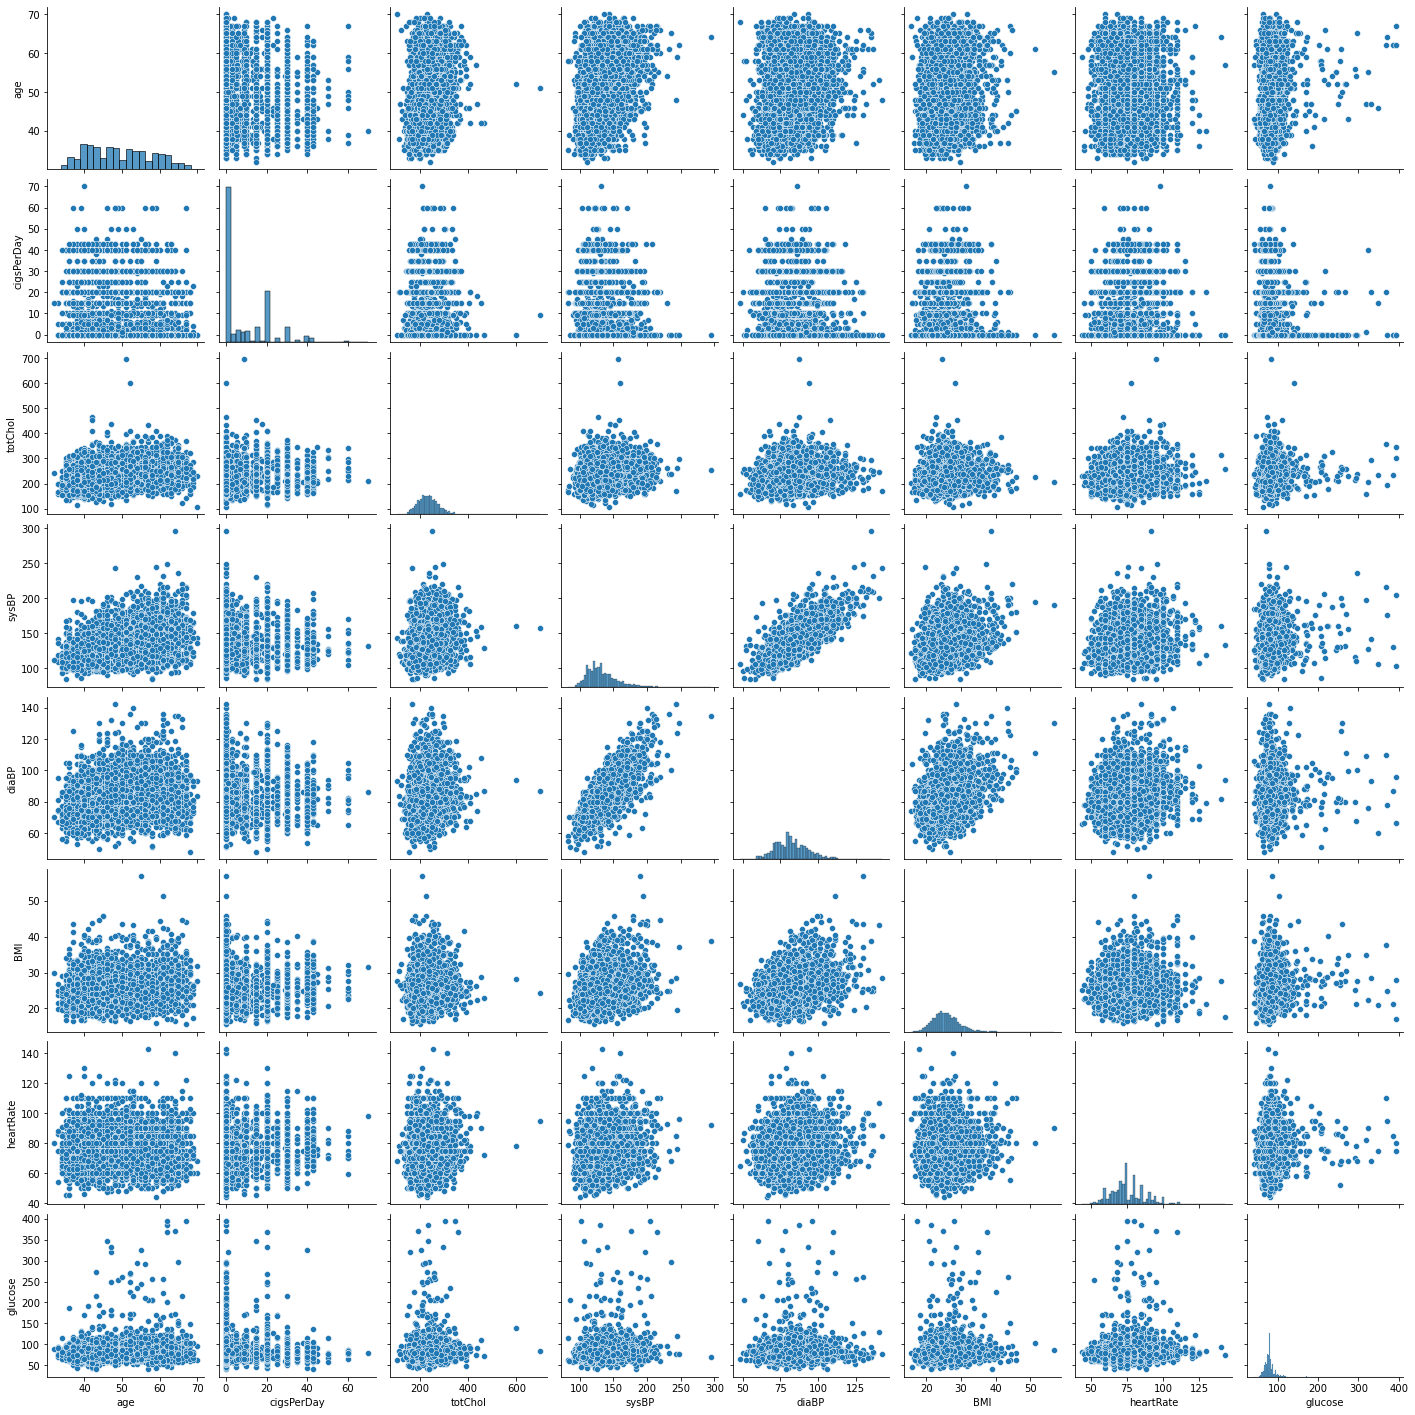

In [362]:
# pairplot tra le variabili continue del dataset
col = ['age', 'cigsPerDay', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose']
ax = sns.pairplot(df[col])
plt.show()

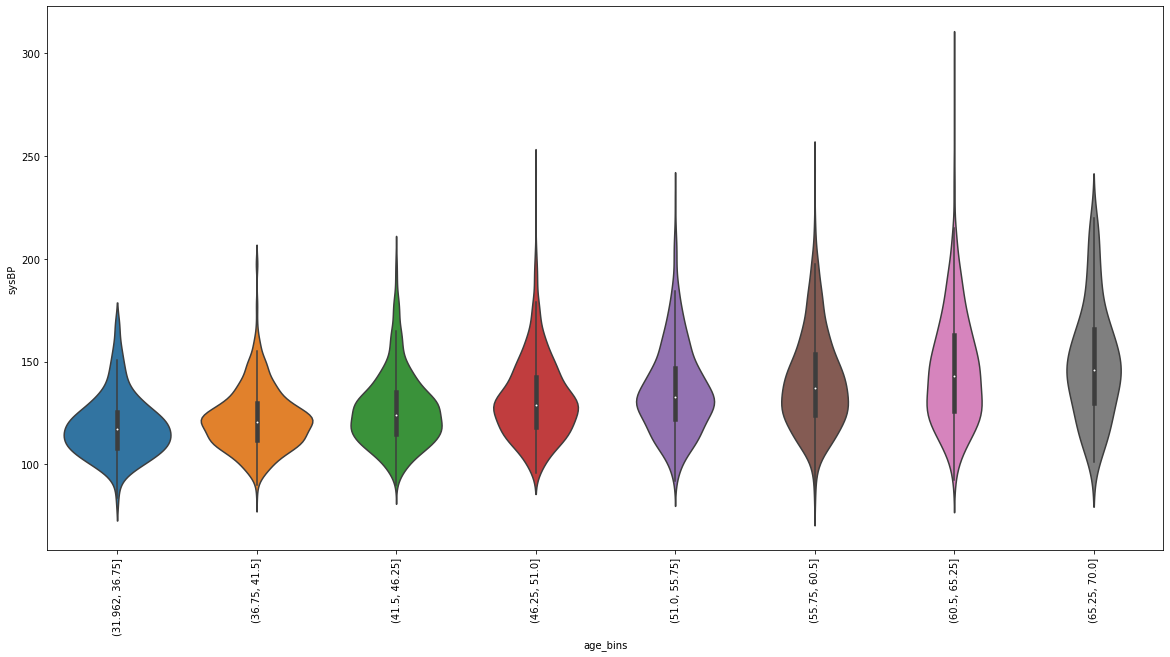

In [363]:
# violin plot tra la classe di età e la pressione arteriosa sistolica
fig, ax = plt.subplots(figsize =(20, 10)) 
sns.violinplot(ax = ax, x = df['age_bins'], y=df['sysBP'] ) 
plt.xticks(rotation='vertical')
plt.show()

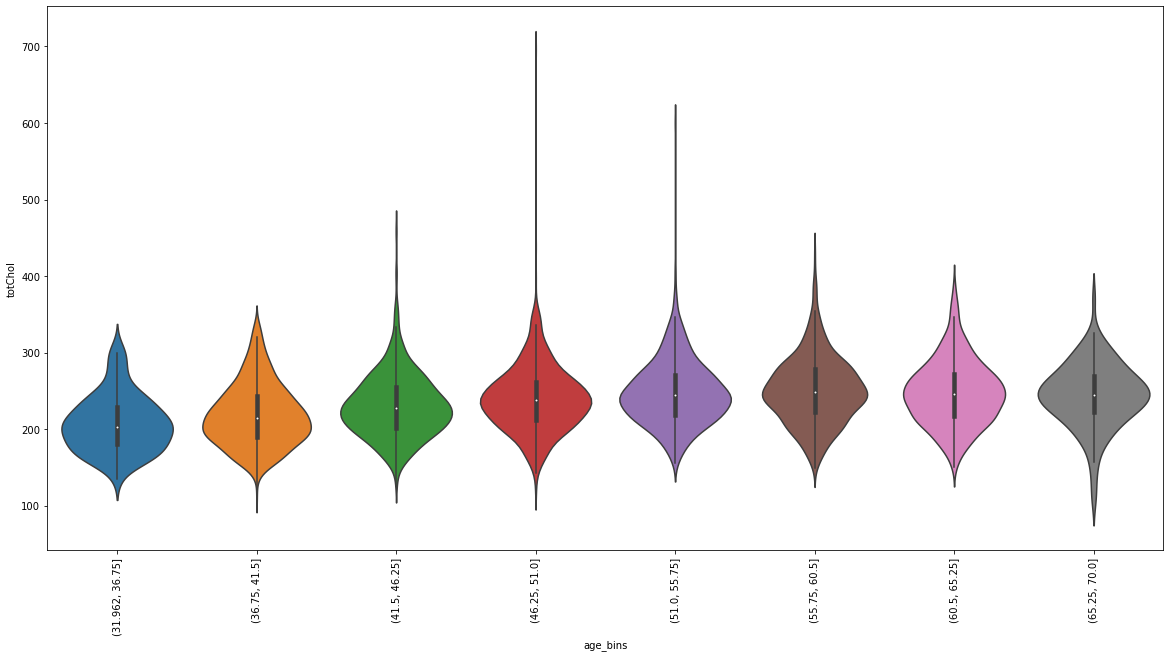

In [364]:
# violin plot tra la classe di età e il colesterolo totale
fig, ax = plt.subplots(figsize =(20, 10)) 
sns.violinplot(ax = ax, x = df['age_bins'], y=df['totChol'] ) 
plt.xticks(rotation='vertical')
plt.show()

### Anomaly detection

Due algoritmi sono utilizzati contemporaneamente per cercare anomalie nel dataset. In tutto 46 entrate anomale sono identificate e, dato il loro numero esiguo, sono rimosse dai dati utilizzati per la costruzione dell'algoritmo di classificazione.

In [98]:
# rimozione della colonna precedentemente inserita
df.drop('age_bins', axis=1, inplace=True)

In [99]:
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

# utilizzo degli algoritmi di anomaly detection
clf = IsolationForest(max_samples='auto', contamination=0.01)
clf.fit(df)
df['Anomaly IF'] = clf.predict(df)

lf = LocalOutlierFactor(n_neighbors=10)
clf.fit(df)
df['Anomaly LOF'] = clf.predict(df)

In [100]:
# anomalie non comuni ai due algoritmi
df[df['Anomaly IF'] != df['Anomaly LOF']]

male  age  education  currentSmoker  cigsPerDay  BPMeds  \
37       1   52        1.0              0         0.0     0.0   
864      0   59        2.0              0         0.0     1.0   
1902     0   52        1.0              1        20.0     1.0   
2275     0   49        2.0              1        30.0     1.0   
4042     1   44        1.0              0         0.0     0.0   
4096     0   56        1.0              0         0.0     0.0   

      prevalentStroke  prevalentHyp  diabetes  totChol  sysBP  diaBP    BMI  \
37                  0             1         1    178.0  160.0   98.0  40.11   
864                 0             1         0    264.0  244.0  124.0  19.61   
1902                0             1         0    161.0  180.0  114.0  32.52   
2275                0             1         0    350.0  174.0   90.0  18.44   
4042                0             1         1    208.0  175.0  101.0  27.93   
4096                0             1         1    273.0  136.0   80.0  27.73   

      heartRate  glucose  TenYearCHD  Anomaly IF  Anomaly LOF  
37         75.0    225.0           0          -1            1  
864        76.0    120.0           1           1           -1  
1902      105.0    104.0           0           1           -1  
2275      110.0     78.0           0           1           -1  
4042       95.0    193.0           0          -1            1  
4096       90.0    210.0           1          -1            1

In [101]:
# anomalie totali trovate
anomalies = df[(df['Anomaly IF'] == -1) | (df['Anomaly LOF'] == -1)]
print(f'Total anomalies: {len(anomalies)}')

Total anomalies: 46


In [102]:
# creazione di un dataset in cui le anomalie sono rimosse
df_anom = df.drop(anomalies.index.values, axis=0)
df_anom = df_anom.drop(['Anomaly IF', 'Anomaly LOF'], axis=1)

### Decision Tree

Un algoritmo è implementato per testare sia differenti criteri di splitting, basato sull'entropia o sull'indice di Gini, sia differenti profondità massime; osservando il grafico di seguito riportato si opta per un albero con profondità 4 e che utilizza l'indice di entropia. Le performance dell'albero scelto sono mostrate prima con l'usilio di una curva ROC, poi attraverso una matrice di confusione, infine, l'albero è visualizzato nella sua interezza ed i risultati raggiunti sono commentati. Prima dell'addestramento dell'albero il dataset viene sottoposto ad oversampling a causa della disparità tra le osservazioni con variabile traget positiva e quelle con variabile traget negativa.

In [146]:
# il dataset senza le anomalie è suddiviso in variabili indipendenti e variabile dipendente
x = df_anom.drop('TenYearCHD', axis=1)
y = df_anom['TenYearCHD']

# splitting in train e test set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3) # test set al 30%

# oversample dei dataset di train per compensare lo sbilanciamento delle osservazioni della variabile dipendente 
oversample = RandomOverSampler(sampling_strategy='minority') # stesso numero di osservazioni con variabile dipendente 0 e 1
x_train, y_train = oversample.fit_resample(x_train, y_train)

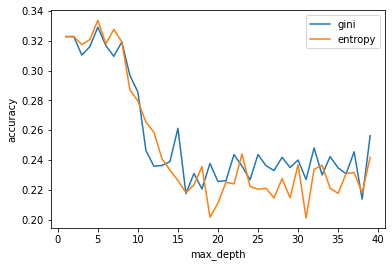

Best entropy accuracy: 0.3338129496402878, at depth: 4
Best gini accuracy: 0.3292181069958848, at depth: 4


In [147]:
from sklearn.metrics import accuracy_score 
from sklearn.metrics import f1_score 

# ricerca della profondità ottimale dell'albero di regressione e confronto tra i due criteri più diffusi per la sua creazione

max_depth = []
acc_gini = []
acc_entropy = []
for i in range(1,40):
    dtree = DecisionTreeClassifier(criterion='gini', max_depth=i)
    dtree.fit(x_train, y_train)
    pred = dtree.predict(x_test)
    acc_gini.append(f1_score(y_test, pred))
    ####
    dtree = DecisionTreeClassifier(criterion='entropy', max_depth=i)
    dtree.fit(x_train, y_train)
    pred = dtree.predict(x_test)
    acc_entropy.append(f1_score(y_test, pred))
    ####
    max_depth.append(i)
d = pd.DataFrame({'acc_gini':pd.Series(acc_gini), 
    'acc_entropy':pd.Series(acc_entropy),
    'max_depth':pd.Series(max_depth)})
    # visualizing changes in parameters
plt.plot('max_depth','acc_gini', data=d, label='gini')
plt.plot('max_depth','acc_entropy', data=d, label='entropy')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.legend()
plt.show()

print(f'Best entropy accuracy: {max(acc_entropy)}, at depth: {acc_entropy.index(max(acc_entropy))}')
print(f'Best gini accuracy: {max(acc_gini)}, at depth: {acc_gini.index(max(acc_gini))}')

In [149]:
# fitting dell'albero ideale
max_depth = 4
criterion='entropy'

dct = tree.DecisionTreeClassifier(max_depth=max_depth, criterion=criterion)
dct.fit(x_train, y_train)

# score dell'albero
score = dct.score(x_test, y_test)
print("High-Dimensionality Score Test:", score)

# previsioni sul test set
proba_dct = dct.predict_proba(x_test)
pred_dct = dct.predict(x_test)

High-Dimensionality Score Test: 0.6399046104928457


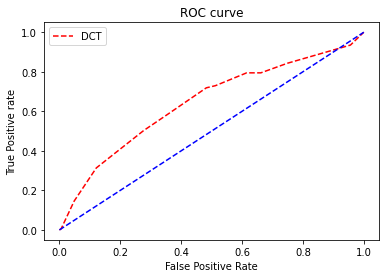

DCT AUC: 0.644


In [150]:
# creazione della curva ROC per il modello
fpr1, tpr1, thresh1 = roc_curve(y_test, proba_dct[:,1], pos_label=1)

# roc per il classificatore casuale
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

# plot roc
plt.plot(fpr1, tpr1, linestyle='--',color='red', label='DCT')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.show()

# auc
roc_auc_dct = auc(fpr1, tpr1)
print(f'DCT AUC: {roc_auc_dct:.3f}')

In [151]:
# classification report dei risultati della previsione
print(classification_report(y_test, pred_dct))

              precision    recall  f1-score   support

           0       0.90      0.65      0.76      1073
           1       0.22      0.58      0.32       185

    accuracy                           0.64      1258
   macro avg       0.56      0.61      0.54      1258
weighted avg       0.80      0.64      0.69      1258



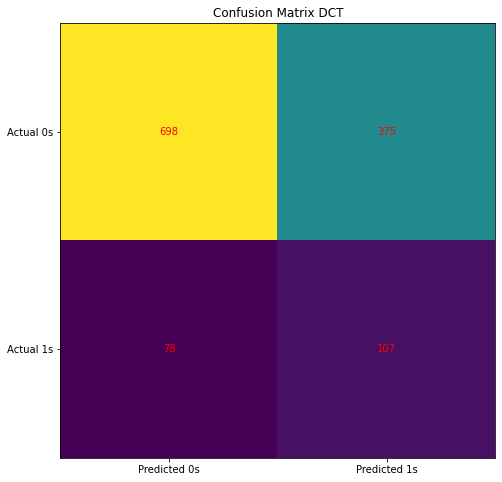

In [152]:
# matrice di confusione per il modello 
cm = confusion_matrix(y_test, pred_dct)
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.title("Confusion Matrix DCT")
plt.show()

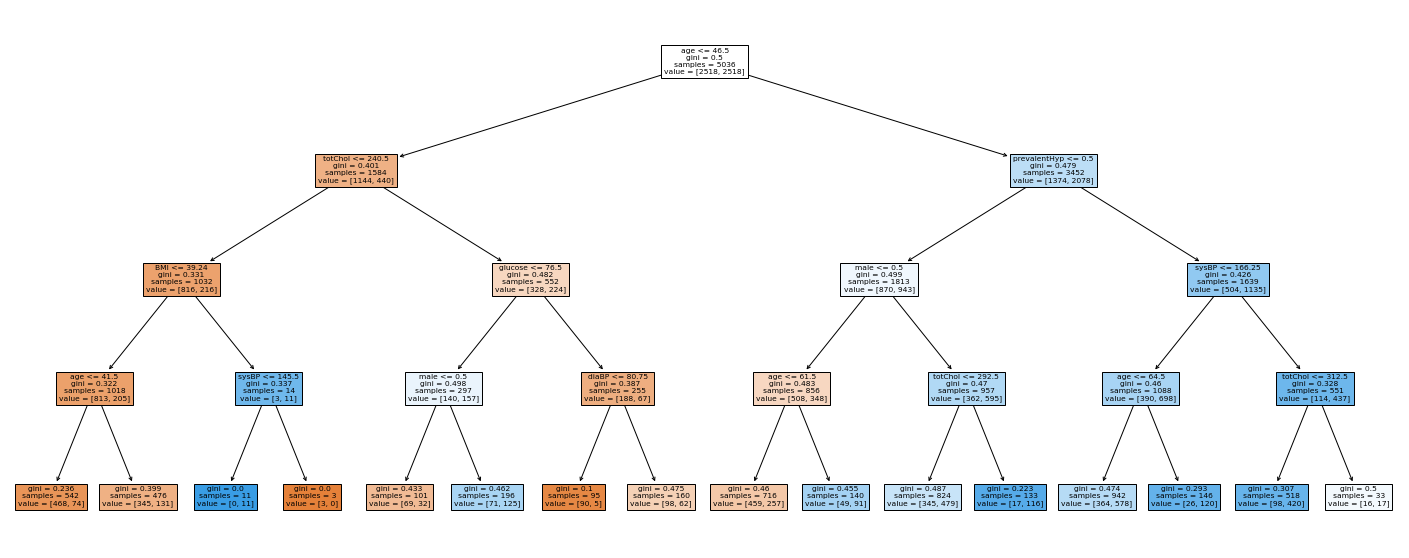

In [109]:
# rappresentazione grafica dell'albero ottenuto
fig = plt.figure(figsize=(25,10))
_ = tree.plot_tree(dct, 
                   feature_names=x.columns,
                   max_depth=max_depth,
                   filled=True)

Come è possibile osservare i risultati ottenuti da quest'albero non sono particolarmente entusiasmanti, esso tende a classificare molti falsi positivi a discapito dei veri negativi. In generale questo classificatore tende a performare bene nell'assegnazione del valore positivo, ma, questo, porta ad una forte sottostima della presenza di valori negativi.

### Boosted Decision Tree

Per cercare di migliorare la capacità di classificazione dell'albero appena ottenuto si procede ad utilizzare un algoritmo di *boosting* i cui risultati sono mostrati di seguito e commentati; inoltre si propone un paragone tra i due alberi di classificazione attraverso un grafico della curva ROC.

In [213]:
# creazione boosted tree per il training e per il test set
feature_names = df_anom.columns[:-1]

train = xgb.DMatrix(data=x_train,
                    label=y_train,
                    feature_names=feature_names)

test = xgb.DMatrix(data=x_test,
                   label=y_test,
                   feature_names=feature_names)

In [214]:
# definizione dei parametri per l'albero
param = {}

# Booster parameters
param['eta']              = 0.1 # learning rate
param['max_depth']        = 30  # maximum depth of a tree
param['subsample']        = 0.8 # fraction of events to train tree on
param['colsample_bytree'] = 0.8 # fraction of features to train tree on

# Learning task parameters
param['objective']   = 'binary:logistic' # objective function
param['eval_metric'] = 'error'           # evaluation metric for cross validation
param = list(param.items()) + [('eval_metric', 'logloss')] + [('eval_metric', 'rmse')]

num_trees = 100  # number of trees to make

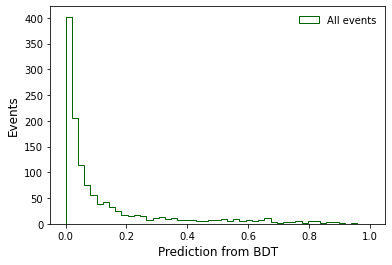

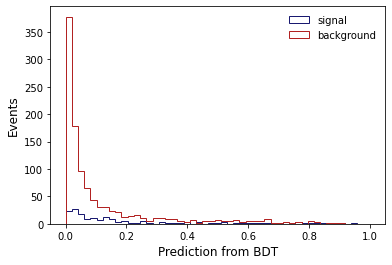

In [215]:
# plot dei risultati
booster = xgb.train(param, train, num_boost_round=num_trees)

predictions = booster.predict(test) # probability

# plot all predictions (both signal and background)
plt.hist(predictions, bins=np.linspace(0,1,50), histtype='step', color='darkgreen', label='All events')

plt.xlabel('Prediction from BDT', fontsize=12)
plt.ylabel('Events', fontsize=12)
plt.legend(frameon=False)
plt.show()

# plot signal and background separately
plt.hist(predictions[test.get_label().astype(bool)], bins=np.linspace(0,1,50),
         histtype='step', color='midnightblue', label='signal')
plt.hist(predictions[~(test.get_label().astype(bool))], bins=np.linspace(0,1,50),
         histtype='step', color='firebrick', label='background')

plt.xlabel('Prediction from BDT',fontsize=12)
plt.ylabel('Events',fontsize=12)
plt.legend(frameon=False)
plt.show()

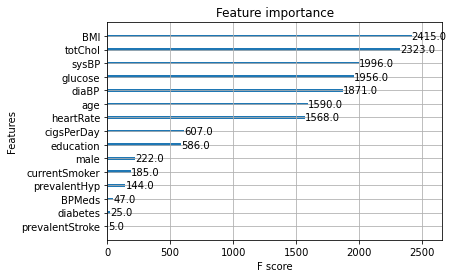

In [216]:
# Importanza stimata di ogni feature
xgb.plot_importance(booster, grid=True);
plt.show()

In [217]:
# trasformazione delle probabilità di appartenenza previste nelle classi binarie
predictions1 = booster.predict(test)
predictions1[predictions1 <= 0.5] = 0.
predictions1[predictions1 > 0.5] = 1.

In [220]:
# classification report dei risultati della previsione
print(classification_report(y_test, predictions1))

              precision    recall  f1-score   support

           0       0.87      0.93      0.90      1073
           1       0.31      0.18      0.23       185

    accuracy                           0.82      1258
   macro avg       0.59      0.56      0.56      1258
weighted avg       0.79      0.82      0.80      1258



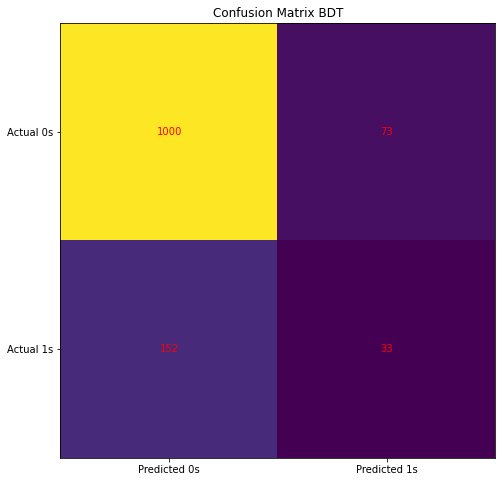

In [218]:
# matrice di confusione per il modello 
cm = confusion_matrix(y_test, predictions1)
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.title("Confusion Matrix BDT")
plt.show()

Al contrario del caso precedente, il boosted decision tree predilige l'individuazione dei valori realmente negativi, mentra lascia un po' a desiderare sulla classificazione della classe positiva. In particolare le stime sono inficiate dalla presenza di molti falsi negativi e, in generale, le predizioni realmente positive sono molto poche; questo è evidenziato dai modestissimi valori di precision e recall mostrati per la classe di interesse.  
Anche il confronto mediante curva ROC non permette di determinare un vincitore assoluto tra i due modelli, ma denota solo la leggera tendenza nel preferire l'albero sotto *boosting*.

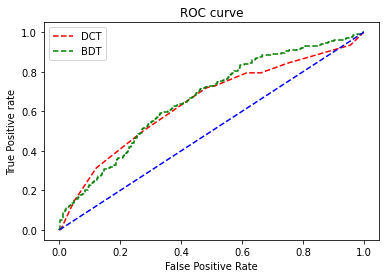

DCT AUC: 0.644
DCT AUC: 0.663


In [219]:
# creazione della curva ROC per i modelli
fpr1, tpr1, thresh1 = roc_curve(y_test, proba_dct[:,1], pos_label=1)
fpr2, tpr2, thresh2 = roc_curve(y_test, predictions, pos_label=1)

# roc per il classificatore casuale
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

# plot roc
plt.plot(fpr1, tpr1, linestyle='--',color='red', label='DCT')
plt.plot(fpr2, tpr2, linestyle='--',color='green', label='BDT')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.show()

# auc
roc_auc_dct = auc(fpr1, tpr1)
roc_auc_bdt = auc(fpr2, tpr2)
print(f'DCT AUC: {roc_auc_dct:.3f}')
print(f'DCT AUC: {roc_auc_bdt:.3f}')

### Rappresentazione albero finale

L'osservazione dell'albero ottenuto evidenzia come alcune variabili siano effettivamente più propense a determinare la presenza di una malattie a lungo termine. Tra queste abbiamo l'età il livello di colesterolo e glucosio nel sangue, la pressione sistolica e diastolica, l'indice BMI e le sigarette fumate.  
In generale però, come già accennato, i risultati ottenuti non sono particolarmente entusiasmanti. Il dataset originale contiene delle variabili continue che presentano delle buone distribuzioni tendenti alla normale e alcune variabili binarie molto sbilanciate. Questo fatto potrebbe aver giocato un ruolo nella bassa resa dell'albero, anche se questa famiglia di classificatori non è molto sensibile allo sbilanciamento nelle variabili input in generale. La spiegazione più probabile delle performance ottenute è che, come si può notare osservando la tabella di correlazione all'inizio dell'analisi, i predittori nel dataset non godono di una buona correlazione con la variabile dipendente e questo implica, inevitabilmente, una bassa capacità predittiva di qualunque modello impiegato. 

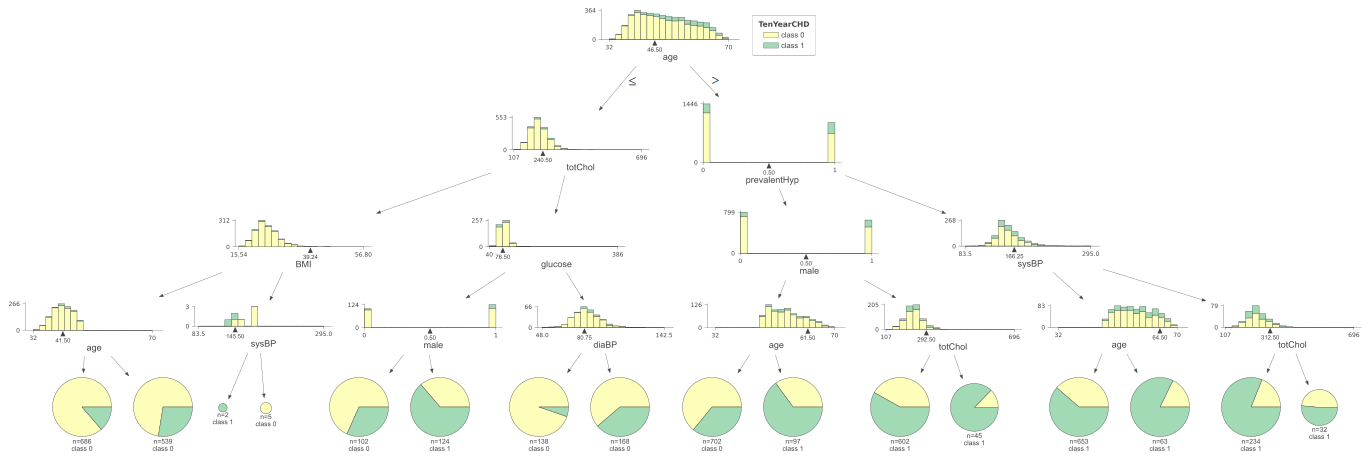

In [117]:
from dtreeviz.trees import dtreeviz

# rappresentazione dettagliata dell'albero finale
viz = dtreeviz(dct, x, y,
               target_name='TenYearCHD',
               feature_names=list(x.columns))

viz

<a id="esercizio2"></a>
## Serie storica

Si legge il dataset `data/globaltemperatures.csv`, si caricano i dati della media della temperatura nei diversi mesi dell'anno dal 1750. La serie dati è poi plottata e le caratteristiche analizzate (tendenza e stagionalità).
Infine si prova a usare la serie storica per produrre le temperature dei successivi 10 anni.

### Serie e sua scomposizione

Il dataset è importato, esso contiene 12 valori nulli, tutti nei primi 3 anni di oservazioni; essi sono risolti con una interpolazione lineare. La serie così completata è mostrata, prima per intero, poi un suo focus sui primi 10 anni di osservazioni per meglio coglierne l'andamento stagionale. Infine è rappresentata una scomposizione della serie nelle sue componenti di *trend*, *stagionalità* e nei residui.

In [229]:
# Recupero del dataset
df = pd.read_csv('./data/globaltemperatures.csv', parse_dates=['dt'], index_col='dt')
temp = df['LandAverageTemperature'] # isolamento media delle temperature
temp

dt
1750-01-01     3.034
1750-02-01     3.083
1750-03-01     5.626
1750-04-01     8.490
1750-05-01    11.573
               ...  
2015-08-01    14.755
2015-09-01    12.999
2015-10-01    10.801
2015-11-01     7.433
2015-12-01     5.518
Name: LandAverageTemperature, Length: 3192, dtype: float64

In [230]:
# controllo l'eventuale presenza di valori nulli
temp[temp.isna()]

dt
1750-11-01   NaN
1751-05-01   NaN
1751-07-01   NaN
1751-10-01   NaN
1751-11-01   NaN
1751-12-01   NaN
1752-02-01   NaN
1752-05-01   NaN
1752-06-01   NaN
1752-07-01   NaN
1752-08-01   NaN
1752-09-01   NaN
Name: LandAverageTemperature, dtype: float64

In [231]:
# I valori nulli sono risolti con una interpolazione lineare
temp.interpolate('linear', inplace=True)

# ogni valore nullo è stato risolto
temp[temp.isna()].any()

False

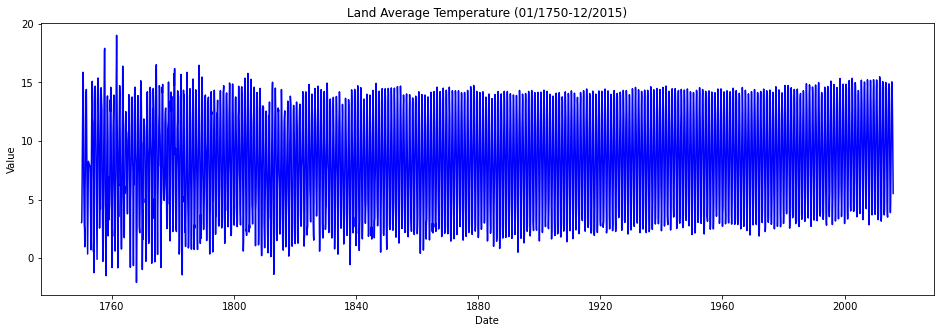

In [232]:
# plot della serie intera 
plt.figure(figsize=(16,5))
plt.plot(temp.index, temp.values, color='blue')
plt.gca().set(title='Land Average Temperature (01/1750-12/2015)', xlabel='Date', ylabel='Value')
plt.show()

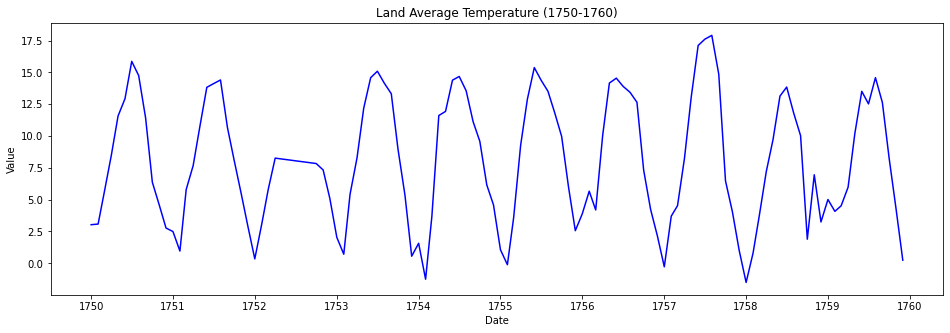

In [233]:
# plot dei primi 10 anni della serie per osservare meglio la stagionalità dei dati
plt.figure(figsize=(16,5))
plt.plot(temp.index[:120], temp.values[:120], color='blue')
plt.gca().set(title='Land Average Temperature (1750-1760)', xlabel='Date', ylabel='Value')
plt.show()

La serie è scomposta secondo un modello additivo. Questo modello è generalmente utilizzato quando la varianza della serie non cambia nel tempo, al contrario, se la varianza fosse aumenta all'aumentare della serie, un modello moltiplicativo sarebbe stato più consigliabile.  

La scomposizione della serie rileva la presenza evidente di stagionalità, probabilmente annuale data la natura dei dati in questione, inoltre, si riscontra anche un trend in crescita, con una pendenza in aumnto per gli ultimi valori misurati.  
Scomposta la serie i residui non sembrano essere autocorrelati, segno che le due componenti di cui sopra forniscono, complessivamente, una buona spiegazione delle osservazioni.

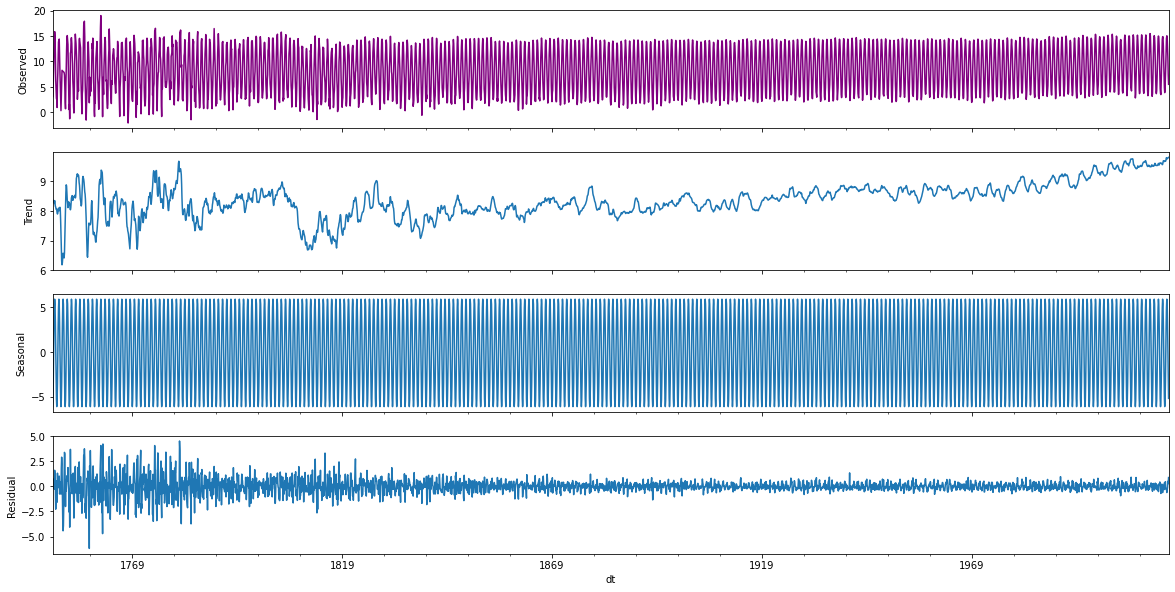

In [234]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

# Scomposizione della serie secondo un modello additivo

result_add = seasonal_decompose(temp, model='additive', extrapolate_trend='freq')

fig, axes = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(20,10))
result_add.observed.plot(ax=axes[0], legend=False, color='purple')
axes[0].set_ylabel('Observed')
result_add.trend.plot(ax=axes[1], legend=False)
axes[1].set_ylabel('Trend')
result_add.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Seasonal')
result_add.resid.plot(ax=axes[3], legend=False)
axes[3].set_ylabel('Residual')
plt.show()

### Studio della varianza

Prima di tutto si studia la relazione tra la media annuale e la deviazione standard annuale della serie. Questo serve per comprendere la loro evoluzione nel tempo e, in particolare, se l'aumentare di una porta all'aumentare dell'altra. In seguito un loro scatterplot è mostrato e, come si può evincere, sebbene il trend aumenti, la deviazione standard resta quasi sempre costante. Guardando la serie non sembrerebbe necessario un aggiustamento per la varianza, in via sperimentale una lambda per una trasformazione Box-Cox è calcolata e, compiuta la trasformazione, il risultato è commentato.

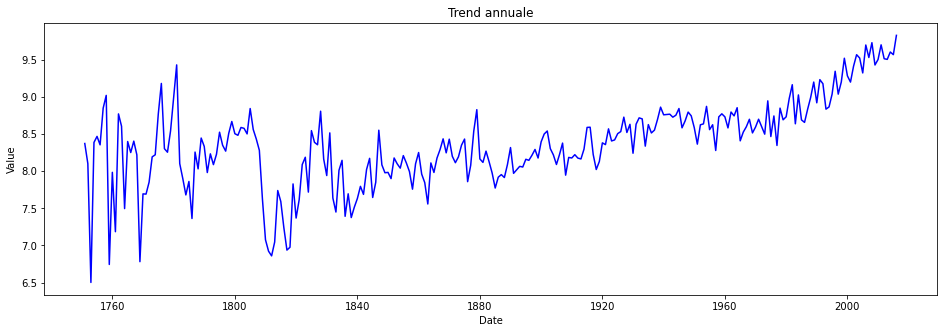

In [235]:
# calcolo della media e della deviazione standard annuale della temperatura 

temp_mean = temp.groupby(pd.Grouper(freq="Y")).mean()
temp_std = temp.groupby(pd.Grouper(freq="Y")).std()

plt.figure(figsize=(16,5))
plt.plot(temp_mean.index, temp_mean.values, color='blue')
plt.gca().set(title='Trend annuale', xlabel='Date', ylabel='Value')
plt.show()

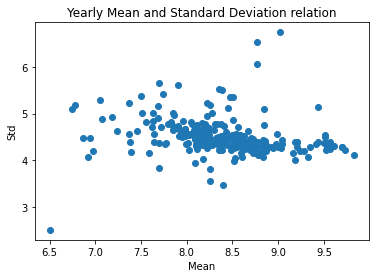

In [236]:
# relazione tra lòa emdia e la deviazione standard nel tempo (componenete annuale)
plt.scatter(temp_mean, temp_std)
plt.gca().set(title='Yearly Mean and Standard Deviation relation', xlabel='Mean', ylabel='Std')
plt.show()

In [237]:
# trasformazione di Box-Cox per risolvere la varianza nella serie
temp_boxcox, best_lambda= stats.boxcox(temp+2.1) # aggiunta di una costante per portare i dati a valori positivi

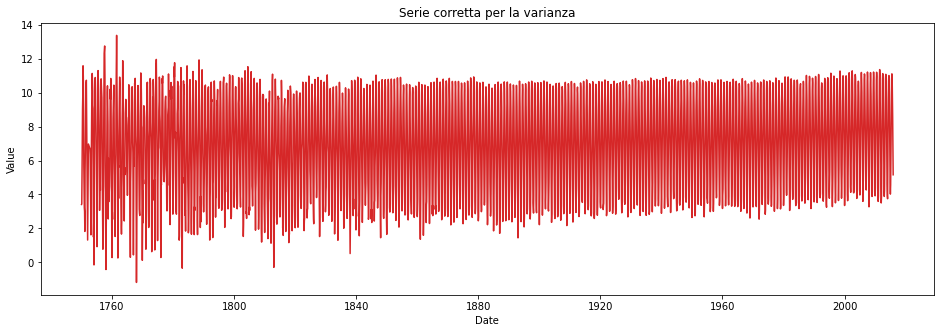

Best lambda for the transformation: 0.8100558835481152


In [238]:
# rappresentazione della serie corretta per la varianza e della lambda usata per tale trasformazione
plt.figure(figsize=(16,5))
plt.plot(temp.index, (temp_boxcox), color='tab:red')
plt.gca().set(title='Serie corretta per la varianza', xlabel='Date', ylabel='Value')
plt.show()
print(f'Best lambda for the transformation: {best_lambda}')

La trasformazione ha, ovviamente, ridotto la varianza complessiva; in questo caso, però, la serie originale è già sufficientemente costante sotto questo punto di vista e, quindi, la trasformazione non è da considerarsi necessaria.

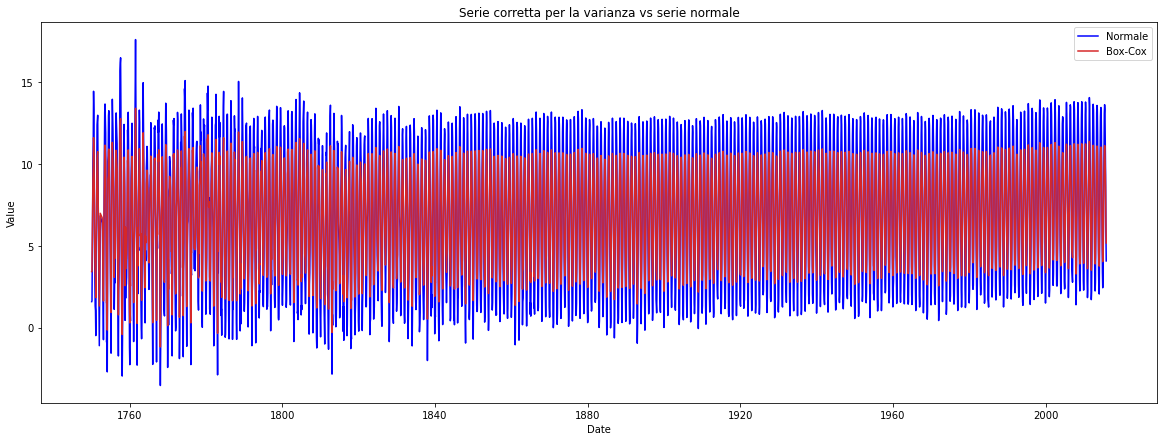

In [239]:
# rappresentazione della serie normale e quella trasformata con la trasformazione Box-Cox
mn = temp.mean()-temp_boxcox.mean()

plt.figure(figsize=(20,7))
plt.plot(temp.index, temp.values-mn, color='blue')
plt.plot(temp.index, (temp_boxcox), color='tab:red')
plt.gca().set(title='Serie corretta per la varianza vs serie normale', xlabel='Date', ylabel='Value')
plt.legend(["Normale", "Box-Cox"])
plt.show()

### Studio del trend

Una regressione lineare sul trend della serie è calcolata e visualizzata per poterne studiare l'andamento; come è evidente la serie risulta possedere un trend positivo crescente. Una differenziazione prima viene applicata alla serie e, in seguito, è mostrato il grafico della serie differenziata, del suo trend e della regressione lineare su quest'ultimo. E' evidente che una semplice differenziazione prima è sufficiente per rendere la serie stazionaria in mediia; più avanti si noterà come anche la sola differenziazione stagionale risolva automaticamente anche la non stazionarietà in media.

A conferma della stazionarietà complessiva della serie è eseguito un Dickey Fuller test che, a questo proposito, restituisce esito positivo.

In [240]:
# preparazione serie per la regressione lineare e cambio di indice
temp_reg = result_add.trend
temp_reg.index = range(0,len(temp))

x = np.array(temp_reg.index).reshape((-1, 1))
y = np.array(temp_reg.values)

In [241]:
from sklearn.linear_model import LinearRegression

# regressione lineare sul trend della serie per vederne l'evoluzione
model = LinearRegression()
model.fit(x, y)
y_pred = pd.Series(model.predict(x), index=temp.index)

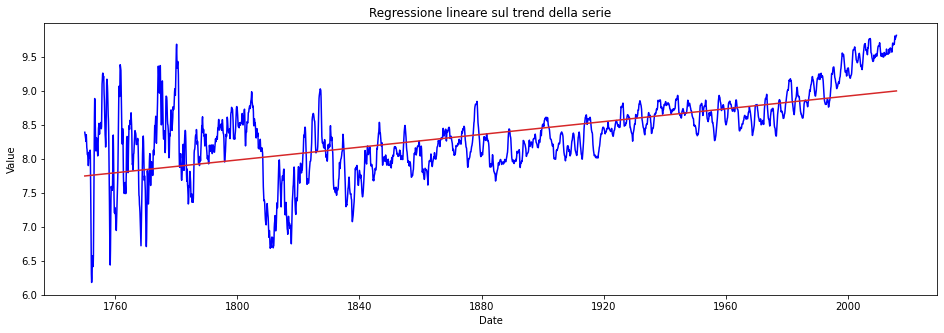

In [242]:
# trend della serie e sua regressione
plt.figure(figsize=(16,5))
plt.plot(y_pred.index, (temp_reg), color='blue')
plt.plot(y_pred.index, (y_pred), color='tab:red')
plt.gca().set(title='Regressione lineare sul trend della serie', xlabel='Date', ylabel='Value')
plt.show()

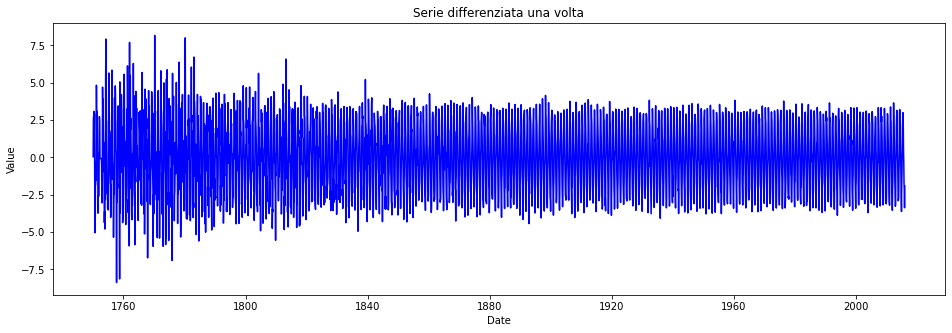

In [243]:
# prova di una differenziazione prima per risolvere il trend
diff1 = temp.diff(1) 
diff1.dropna(inplace=True)

# plot della serie differenziata
plt.figure(figsize=(16,5))
plt.plot(diff1.index, (diff1), color='blue')
plt.gca().set(title='Serie differenziata una volta', xlabel='Date', ylabel='Value')
plt.show()

In [244]:
from statsmodels.tsa.stattools import adfuller

# Dickey-Fuller test per la stazionarietà della serie differenziata
adfuller(diff1) # serie è stazionaria

(-15.992098587072059,
 6.653638042894063e-29,
 27,
 3163,
 {'1%': -3.4324191163220705,
  '5%': -2.862454208853862,
  '10%': -2.567256654467574},
 7427.406274032188)

In [245]:
# regressione lineare sulla serie differenziata
result_add_d1 = seasonal_decompose(diff1, model='additive', extrapolate_trend='freq')
temp_reg_d1 = result_add_d1.trend
temp_reg_d1.index = range(0,len(diff1))

x_d1 = np.array(temp_reg_d1.index).reshape((-1, 1))
y_d1 = np.array(temp_reg_d1.values)

model_d1 = LinearRegression()
model_d1.fit(x_d1, y_d1)
y_pred_d1 = pd.Series(model_d1.predict(x_d1), index=diff1.index)

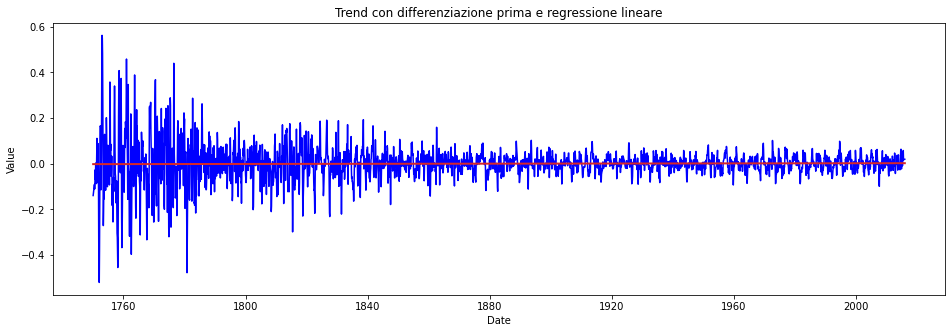

In [246]:
# plot del trend differenziato una volta e relativa regressione lineare
plt.figure(figsize=(16,5))
plt.plot(y_pred_d1.index, (temp_reg_d1), color='blue')
plt.plot(y_pred_d1.index, (y_pred_d1), color='tab:red', linewidth=2)
plt.gca().set(title='Trend con differenziazione prima e regressione lineare', xlabel='Date', ylabel='Value')
plt.show()

### Studio della stagionalità

Osservando la serie e conoscendo la natura dei dati una stagionalità di 12 mesi è testata. Una differenziazione stagionale è quindi calcolata e il suo grafico è mostrato; un focus sui primi 10 anni mostra come, dopo la differenziazione, la stagionalità è  risolta.  
Ad ulteriore conferma di ciò vengono mostrati i lag plot della serie sui suoi primi 12 periodi, sia per la serie normale che per quella differenziata stagionalmente. La serie normale mostra la presenza di una forte correlazione su diversi periodi, segno della presenza della stagioanlità, mentre la serie differenziata mostra una distribuzione casuale delle osservazioni; come unica osservazione si può notare solo un minimo di stagionalità residua nel grafico del dodicesimo lag.

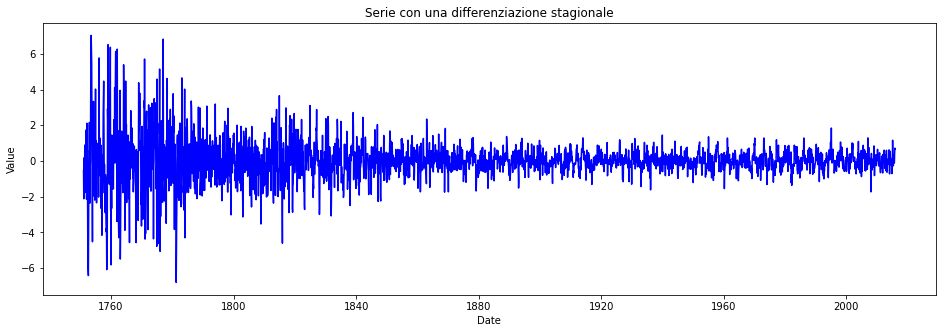

In [247]:
# data la natura della serie un periodo di 12 mesi è scelto per compiere la differenziazione stagionale
diff12 = temp.diff(12) 
diff12.dropna(inplace=True)

# rappresentazione della serie differenziata 
plt.figure(figsize=(16,5))
plt.plot(diff12.index, (diff12), color='blue')
plt.gca().set(title='Serie con una differenziazione stagionale', xlabel='Date', ylabel='Value')
plt.show()

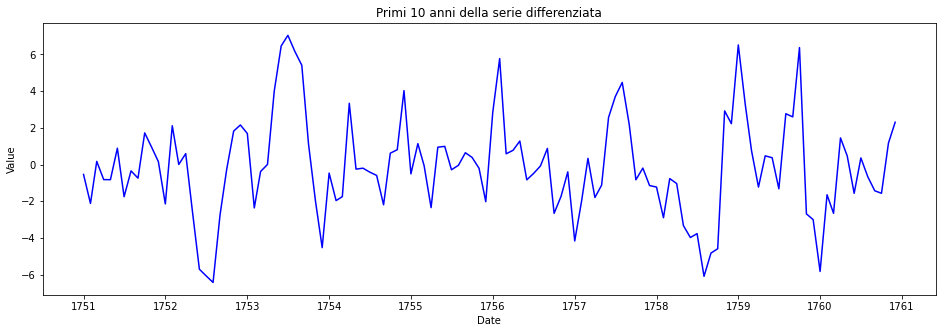

In [248]:
# Primi 10 anni della serie differenziata, la stagionalità è scomparsa
plt.figure(figsize=(16,5))
plt.plot(diff12.index[:120], diff12.values[:120], color='blue')
plt.gca().set(title='Primi 10 anni della serie differenziata', xlabel='Date', ylabel='Value')
plt.show()

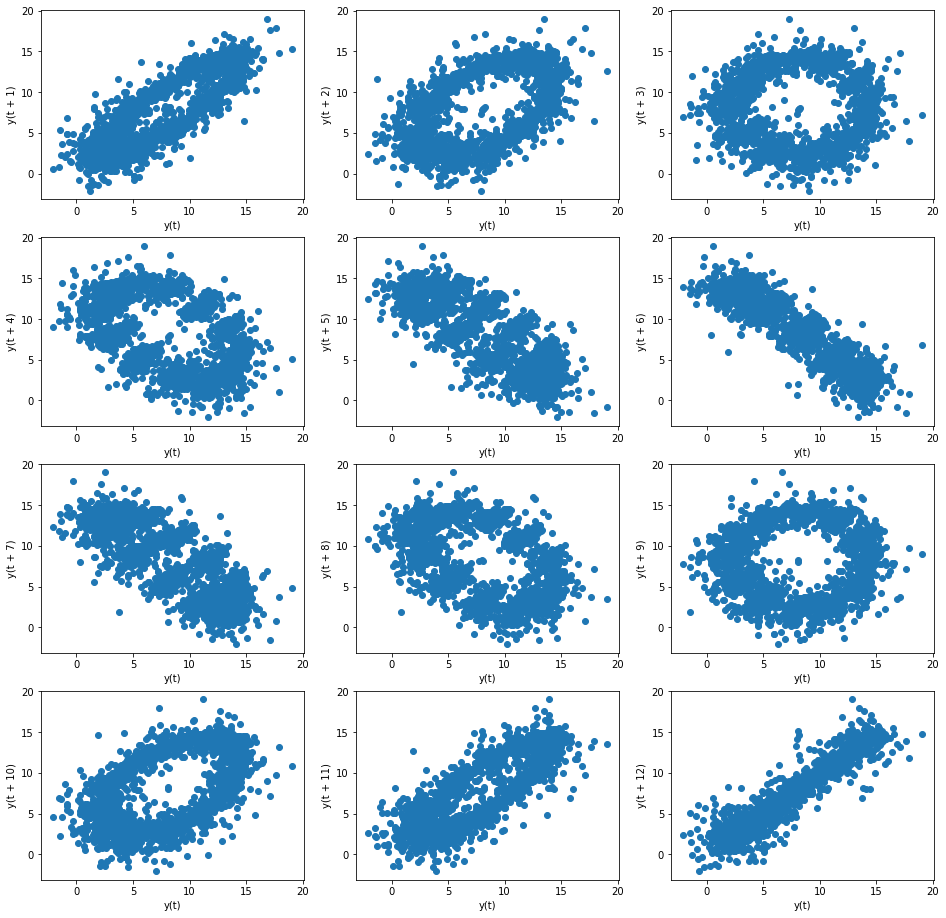

In [249]:
# lag scatterplot della serie base, chiara presenza di stagionalità

fig = plt.figure(figsize=(16,16))

fig.add_subplot(4, 3, 1)
pd.plotting.lag_plot(temp, lag=1)

fig.add_subplot(4, 3, 2)
pd.plotting.lag_plot(temp, lag=2)

fig.add_subplot(4, 3, 3)
pd.plotting.lag_plot(temp, lag=3)

fig.add_subplot(4, 3, 4)
pd.plotting.lag_plot(temp, lag=4)

fig.add_subplot(4, 3, 5)
pd.plotting.lag_plot(temp, lag=5)

fig.add_subplot(4, 3, 6)
pd.plotting.lag_plot(temp, lag=6)

fig.add_subplot(4, 3, 7)
pd.plotting.lag_plot(temp, lag=7)

fig.add_subplot(4, 3, 8)
pd.plotting.lag_plot(temp, lag=8)

fig.add_subplot(4, 3, 9)
pd.plotting.lag_plot(temp, lag=9)

fig.add_subplot(4, 3, 10)
pd.plotting.lag_plot(temp, lag=10)

fig.add_subplot(4, 3, 11)
pd.plotting.lag_plot(temp, lag=11)

fig.add_subplot(4, 3, 12)
pd.plotting.lag_plot(temp, lag=12)

plt.show()

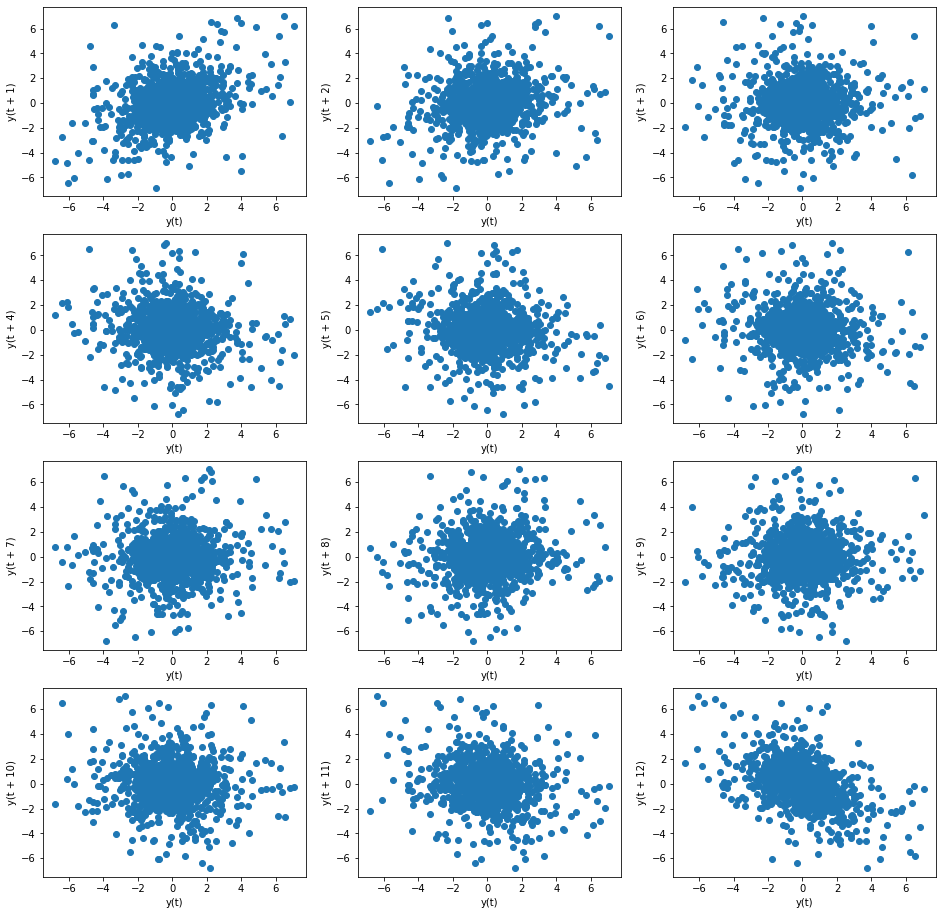

In [212]:
# lag scatterplot della serie differenziata, la stagionalità è quasi del tutto scomparsa

fig = plt.figure(figsize=(16,16))

fig.add_subplot(4, 3, 1)
pd.plotting.lag_plot(diff12, lag=1)

fig.add_subplot(4, 3, 2)
pd.plotting.lag_plot(diff12, lag=2)

fig.add_subplot(4, 3, 3)
pd.plotting.lag_plot(diff12, lag=3)

fig.add_subplot(4, 3, 4)
pd.plotting.lag_plot(diff12, lag=4)

fig.add_subplot(4, 3, 5)
pd.plotting.lag_plot(diff12, lag=5)

fig.add_subplot(4, 3, 6)
pd.plotting.lag_plot(diff12, lag=6)

fig.add_subplot(4, 3, 7)
pd.plotting.lag_plot(diff12, lag=7)

fig.add_subplot(4, 3, 8)
pd.plotting.lag_plot(diff12, lag=8)

fig.add_subplot(4, 3, 9)
pd.plotting.lag_plot(diff12, lag=9)

fig.add_subplot(4, 3, 10)
pd.plotting.lag_plot(diff12, lag=10)

fig.add_subplot(4, 3, 11)
pd.plotting.lag_plot(diff12, lag=11)

fig.add_subplot(4, 3, 12)
pd.plotting.lag_plot(diff12, lag=12)

plt.show()

### Previsioni per i 10 anni successivi

Le previsioni sono ottenute attraverso due diversi modelli: un ARIMA e un UCM.

Il modello ARIMA utilizzato, calcolato automaticamente, è un ARIMA(3,0,2)(2,1,0)[12].  
Dopo aver stabilito il modello migliore esso viene prima applicato alla serie storica completa a cui sono stati rimossi gli ultimi 20 anni di osservazioni, così facendo la capacità predittiva del modello può essere confrontata ai dati reali e stimata. Infine il modello validato è impiegato per predire i 10 anni successivi alla serie stessa. Come metrica di paragone è calcolato il MAPE e, per l'ARIMA, risulta essere di 5.17%.  

Per quanto riguarda le componenti del modello UCM come livello è utilizzato un *local linear trend*, mentre la stagionalità è modellata con sole 3 sinusoidi di periodo 12. Il modello è quindi costruito ed analizzato in modo similare al precedente; il suo MAPE risulta essere di 4.41%. Anche questo secondo modello è utilizzato per ottenere le previsioni dei 10 anni successivi alla serie ed il loro grafico è poi visualizzato.

#### ARIMA

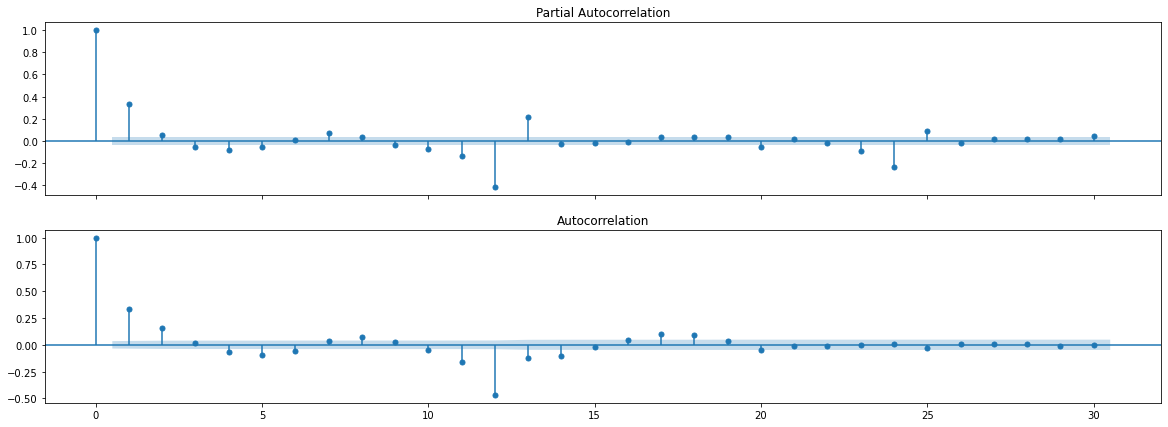

In [228]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# PACF e ACF per la serie differenziata stagionalmente
fig, axes = plt.subplots(ncols=1, nrows=2, sharex=True, figsize=(20,7))
ax0 = plot_acf(diff12, lags = 30, ax=axes[1]);
ax1 = plot_pacf(diff12, lags = 30, ax=axes[0])


In [251]:
# per testare il modello isolo gli ultimi 20 anni della serie 
past = temp[:-240]
future = temp[-240:]

In [225]:
# Creazione di un modello ARIMA stagionale attraverso la funzione di stima automatica dei coefficienti
smodel = pm.auto_arima(past, start_p=0, start_q=0,
                       test='adf',
                       max_p=3, max_q=3, m=12,
                       start_P=0, seasonal=True,
                       d=None, D=1, trace=True,
                       error_action='ignore',  
                       suppress_warnings=True, 
                       stepwise=True)

smodel.summary() #Best model:  ARIMA(3,0,2)(2,1,0)[12]

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=inf, Time=2.27 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=9083.005, Time=0.21 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=7963.699, Time=2.06 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=4.86 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=9081.042, Time=0.26 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=8729.048, Time=0.60 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=7735.923, Time=6.12 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=22.49 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=6.38 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=8123.940, Time=4.35 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=7731.915, Time=7.02 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=7960.805, Time=2.28 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=28.12 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=7.29 sec
 ARIMA(3,0,0)(2,1,0)[12] intercept   : AIC=7730

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 2952
Model:             SARIMAX(3, 0, 2)x(2, 1, [], 12)   Log Likelihood               -3848.357
Date:                             Wed, 20 Jul 2022   AIC                           7712.715
Time:                                     22:37:18   BIC                           7760.604
Sample:                                          0   HQIC                          7729.958
                                            - 2952                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3156      0.063     20.762      0.000       1.191       1.440
ar.L2         -0.9480      0.085    -11.205      0.000      -1.114      -0.782
ar.L3          0.1612      0.029      5.501      0.000       0.104       0.219
ma.L1         -0.9818      0.060    -16.355      0.000      -1.099      -0.864
ma.L2          0.6778      0.060     11.220      0.000       0.559       0.796
ar.S.L12      -0.5947      0.011    -52.775      0.000      -0.617      -0.573
ar.S.L24      -0.2720      0.010    -27.014      0.000      -0.292      -0.252
sigma2         0.8011      0.010     77.558      0.000       0.781       0.821
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              5138.76
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               0.06   Skew:                             0.36
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

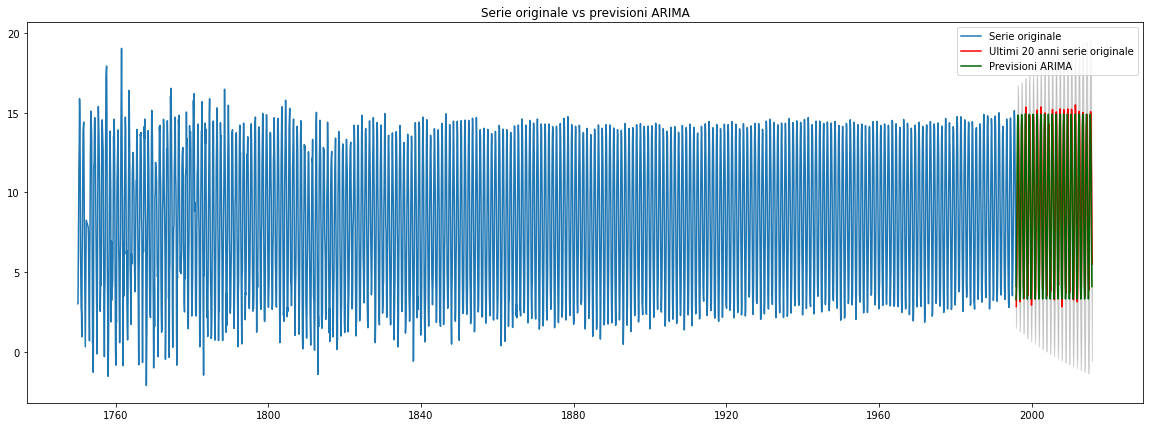

In [243]:
# predizione degli ultimi 20 anni della serie
n_periods = len(future)
fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(past.index[-1], periods=n_periods, freq='MS')

fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# rappresentazione della serie completa sovrapposta alle previsioni per i suoi ultimi 20 anni
plt.figure(figsize=(20, 7))

plt.plot(past)
plt.plot(future, color='red')
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("Serie originale vs previsioni ARIMA")
plt.legend(["Serie originale", "Ultimi 20 anni serie originale", "Previsioni ARIMA"])
plt.show()

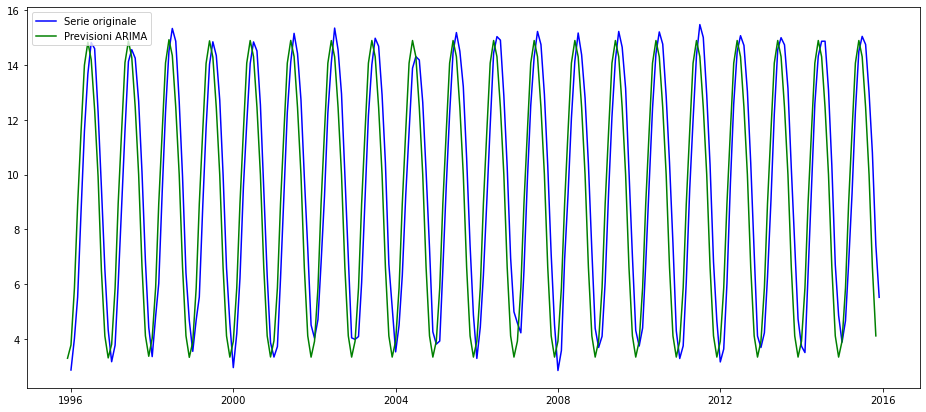

In [231]:
# focus sui soli ultimi 20 anni predetti vs i 20 anni di osservazioni
plt.figure(figsize=(16, 7))
plt.plot(future, color='blue')
plt.plot(fitted_series, color='green')
plt.legend(["Serie originale", "Previsioni ARIMA"])
plt.show()

In [232]:
# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(future, fitted.flatten())/ future))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

Mean Absolute Percentage Error (MAPE): 5.17 %


In [233]:
# calcolo dei residui di previsione
residuals = future - fitted

I reisdui del modello risultano distribuiti normalmente e senza traccia di autocorrelazione

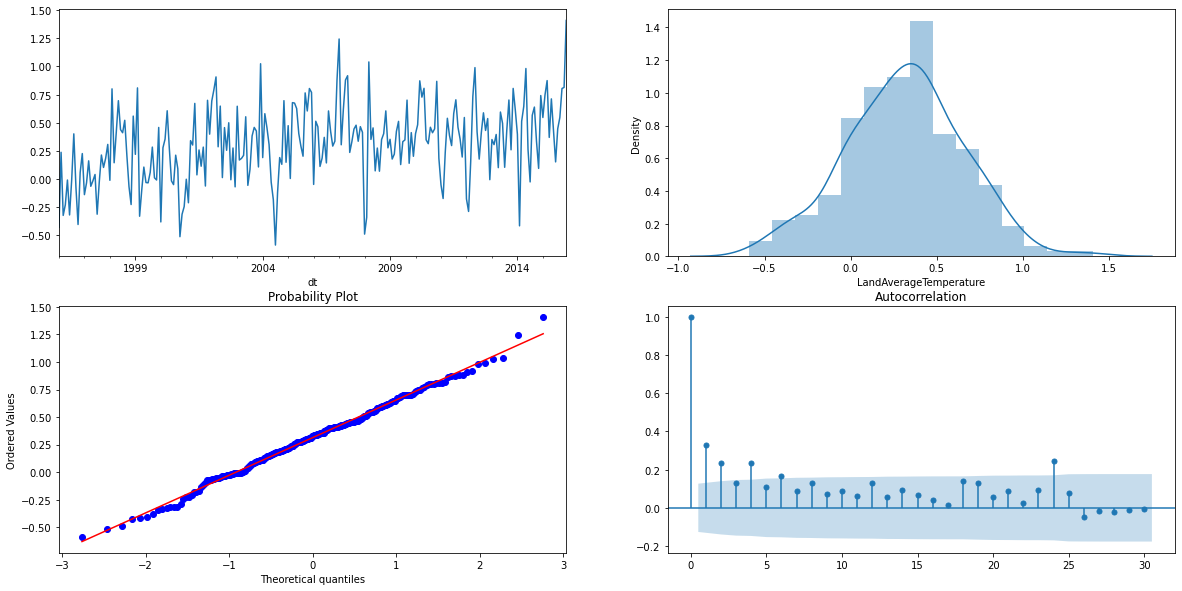

In [248]:
# studio complessivo residui

fig, (ax, ay) = plt.subplots(2,2, figsize=(20,10))

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    sns.distplot(residuals, ax=ax[1]);
    stats.probplot(residuals, plot=ay[0])
    fig3 = plot_acf(residuals, lags=30, ax=ay[1])
    residuals.plot(ax=ax[0])
    
plt.show()

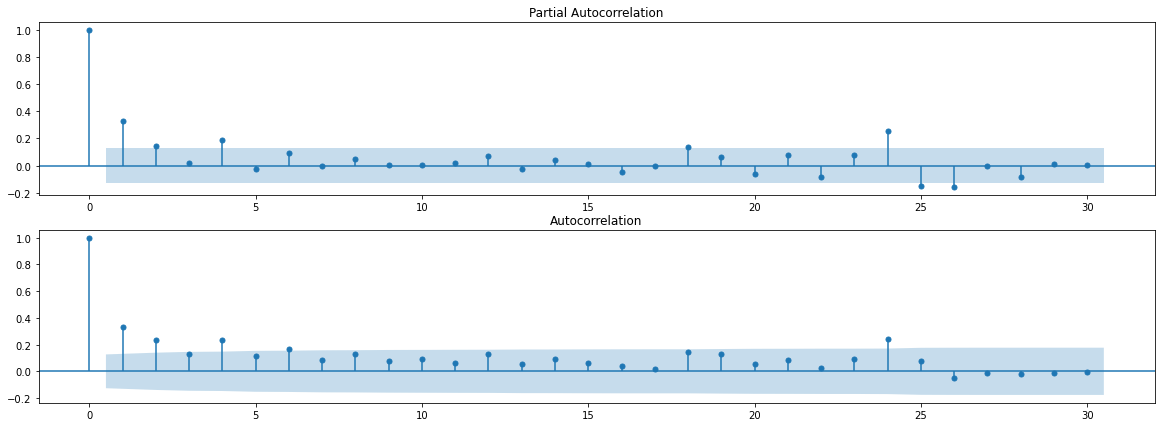

In [250]:
# PACF e ACF dei residui 
fig, ax = plt.subplots(2,1, figsize=(20,7))

plot_acf(residuals, lags = 30, ax=ax[1]);
fig = plot_pacf(residuals, lags = 30, ax=ax[0]) 

Predizioni per i 10 anni successivi

In [258]:
from pmdarima.arima import ARIMA

# Creazione di un modello ARIMA stagionale attraverso la funzione di stima automatica dei coefficienti
smodel_pre = pm.ARIMA(order=(3,0,2), 
                  seasonal_order=(2, 1, 0, 12), 
                  method='lbfgs', 
                  maxiter=50, 
                  suppress_warnings=True, 
                  scoring='mse', 
                  with_intercept=True)
smodel_pre.fit(temp)

ARIMA(order=(3, 0, 2), seasonal_order=(2, 1, 0, 12), suppress_warnings=True)

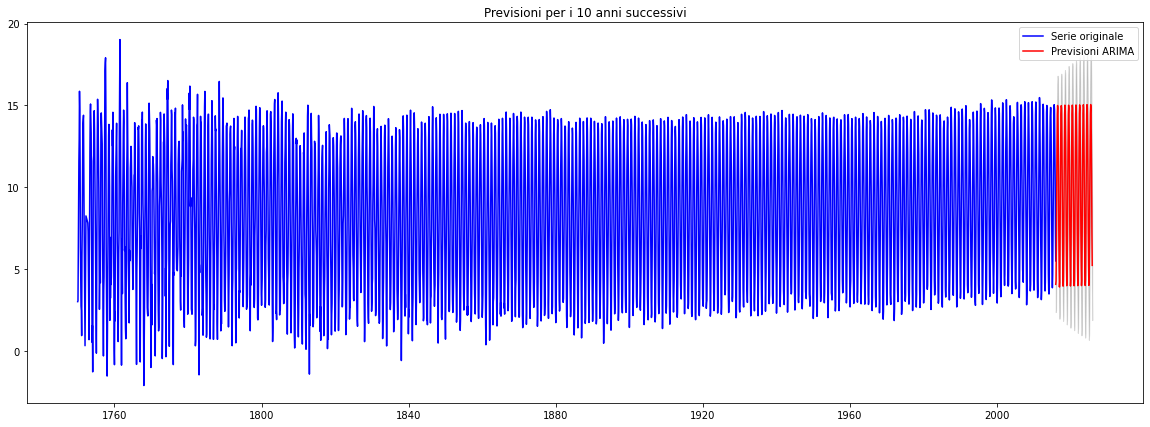

In [260]:
# predizione 10 anni successivi alla serie
n_periods = 120
fitted, confint = smodel_pre.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(temp.index[-1], periods=n_periods, freq='MS')

fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# rappresentazione della serie completa sovrapposta alle previsioni per i suoi ultimi 20 anni
plt.figure(figsize=(20, 7))

plt.plot(temp, color='blue')
plt.plot(fitted_series, color='red')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("Previsioni per i 10 anni successivi")
plt.legend(["Serie originale", "Previsioni ARIMA"])
plt.show()

#### UCM

In [252]:
from statsmodels.tsa.statespace.structural import UnobservedComponents

# definizione modello UCM
past = past.asfreq('MS')
future = future.asfreq('MS')

model_ucm = UnobservedComponents(past, level='lltrend',
                                 freq_seasonal =[{'period': 12,
                                                  'harmonics': 3},
                                                ],
                                 stochastic_seasonal= True,
                                 autoregressive=None,
                                 exog=None,
                                 mle_regression=True
                                 )

In [253]:
# fit del modello sulla serie a cui sono stati rimossi gli ultimi 20 anni per test e creazione delle previsioni
ucm_fit = model_ucm.fit()
pred_ucm = ucm_fit.predict(start=future.index[0], end = future.index.max())

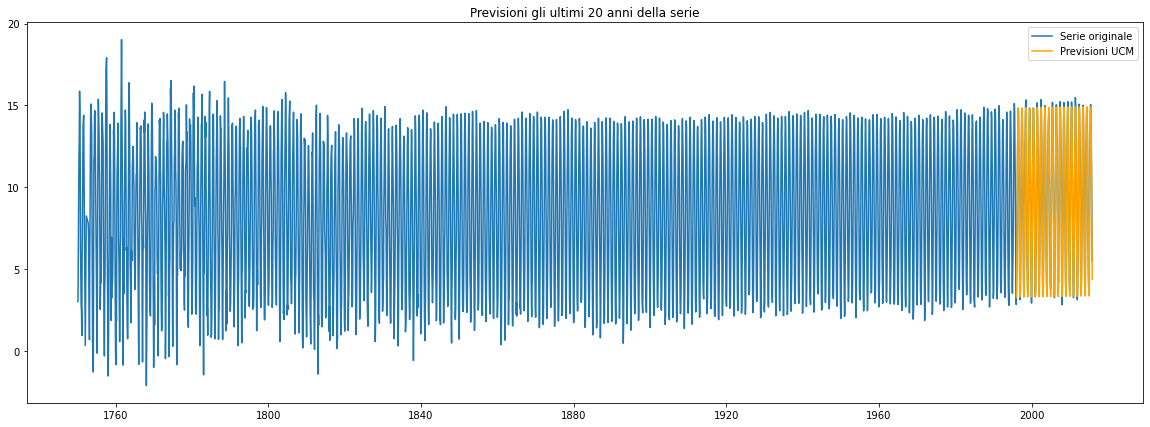

In [340]:
# previsioni del modello vs ultimi 20 anni della serie
fig = plt.figure(figsize=(20, 7))
plt.plot(temp)
plt.plot(pred_ucm, color='orange')
plt.title("Previsioni gli ultimi 20 anni della serie")
plt.legend(["Serie originale", "Previsioni UCM"])
plt.show()

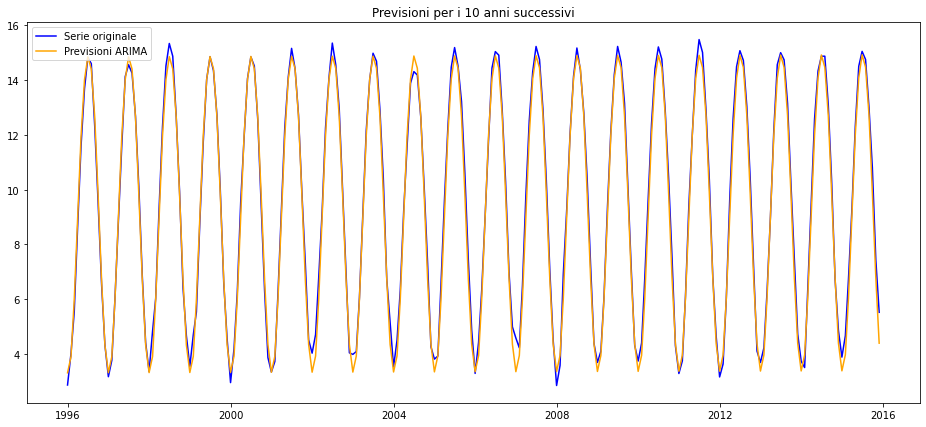

In [341]:
# focus sulle sole previsioni
plt.figure(figsize=(16, 7))
plt.plot(future, color='blue')
plt.plot(pred_ucm, color='orange')
plt.title("Previsioni per i 10 anni successivi")
plt.legend(["Serie originale", "Previsioni ARIMA"])
plt.show()

In [344]:
# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(future, np.array(pred_ucm))/ future))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

Mean Absolute Percentage Error (MAPE): 4.41 %


In [342]:
# calcolo dei residui 
residuals_ucm = future - pred_ucm

Anche questi residui sono normalmente distribuiti e non autocorrelati

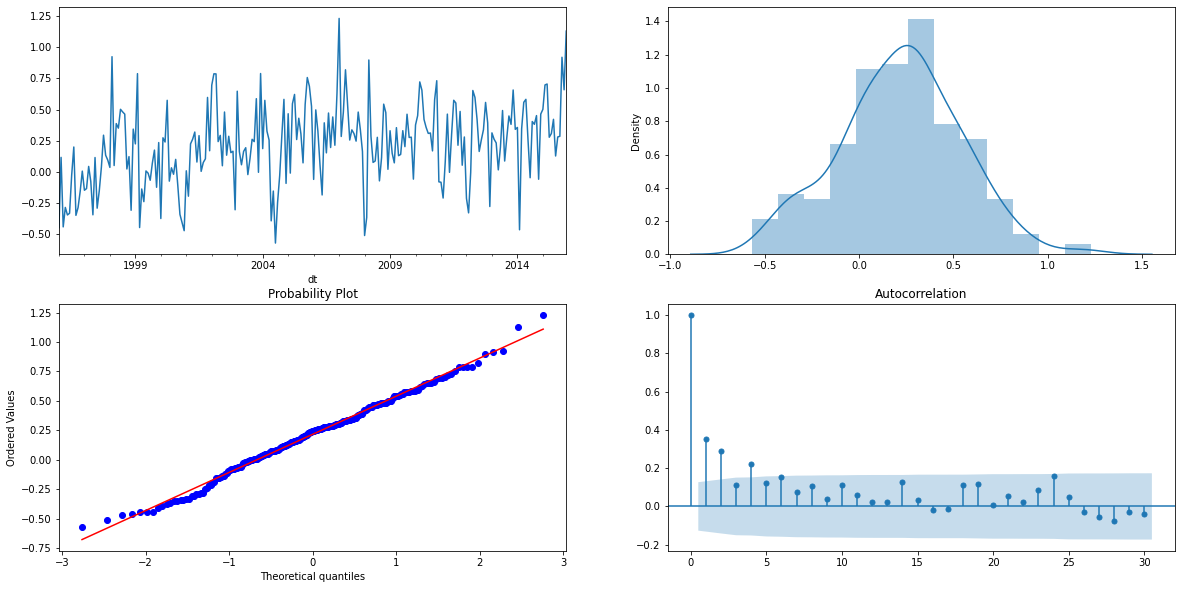

In [343]:
# studio dei residui
fig, (ax, ay) = plt.subplots(2,2, figsize=(20,10))

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    sns.distplot(residuals_ucm, ax=ax[1]);
    stats.probplot(residuals_ucm, plot=ay[0])
    fig3 = plot_acf(residuals_ucm, lags=30, ax=ay[1])
    residuals_ucm.plot(ax=ax[0])
    
plt.show()

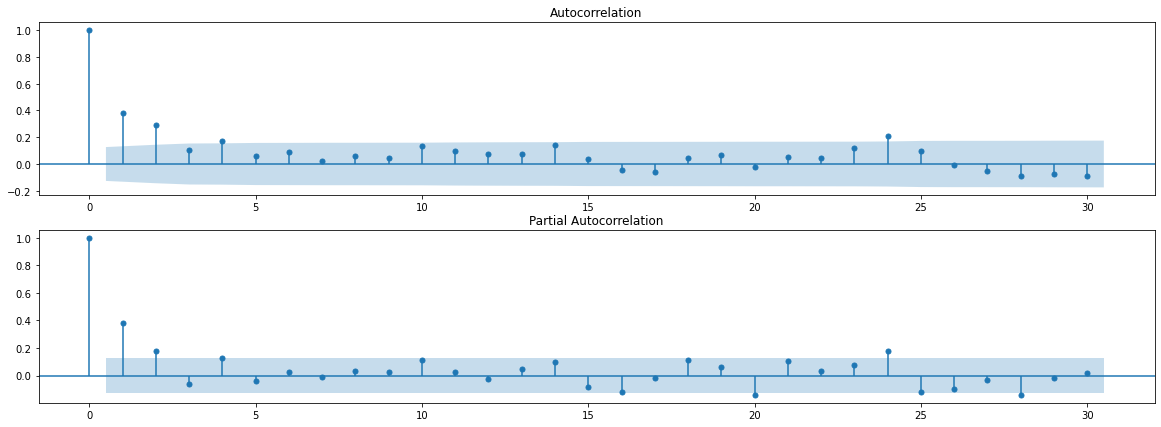

In [270]:
# PACF e ACF dei residui 
fig, ax = plt.subplots(2,1, figsize=(20,7))

plot_acf(residuals_ucm, lags = 30, ax=ax[0]);
fig = plot_pacf(residuals_ucm, lags = 30, ax=ax[1]) 

Previsioni per i 10 anni successivi

In [301]:
# definizione modello UCM per le previsioni 10 anni avanti

temp_ucm = temp.asfreq('MS')
model_ucm_pre = UnobservedComponents(temp_ucm, level='lltrend',
                                     seasonal =12,
                                     stochastic_seasonal= True,
                                     autoregressive=None,
                                     exog=None,
                                     mle_regression=True,
                                     use_exact_diffuse=True
                                     )

In [302]:
# fit del modello sulla serie a cui sono stati rimossi gli ultimi 20 anni per test e creazione delle previsioni
periods = pd.date_range('2016-01-01', periods=n_periods, freq="MS")
ucm_fit_pre = model_ucm_pre.fit()
pred_ucm = ucm_fit_pre.predict(start=periods.min(), end = periods.max())

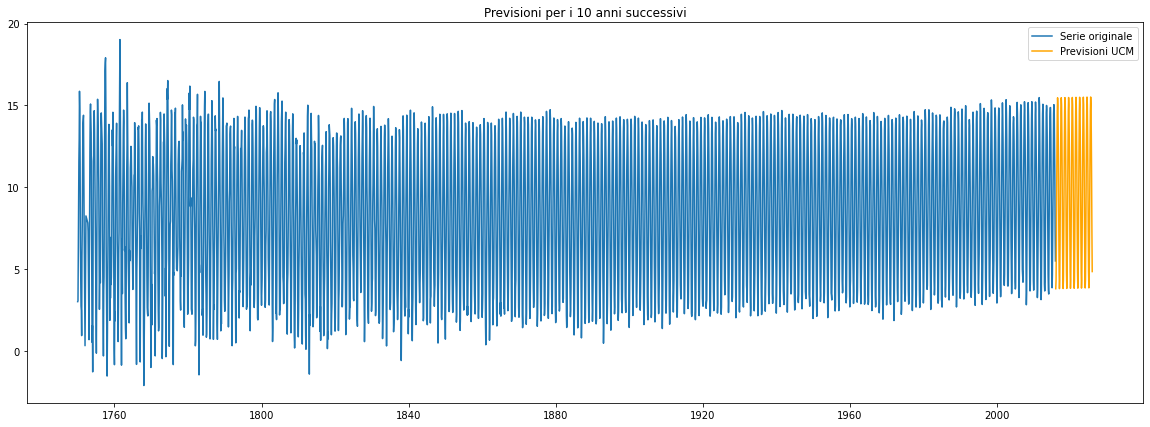

In [304]:
# previsioni del modello vs ultimi 20 anni della serie
fig = plt.figure(figsize=(20, 7))
plt.plot(temp)
plt.plot(pred_ucm, color='orange')
plt.title("Previsioni per i 10 anni successivi")
plt.legend(["Serie originale", "Previsioni UCM"])
plt.show()

<a id="esercizio3"></a>
## Predizione di malattie cardiache

Si prevede la probabilità di una malattia cardiaca o meno, attraverso un dataset che classifica se i pazienti hanno o meno malattie cardiache in base alle caratteristiche in esso contenute. Cercheremo di utilizzare questi dati per creare un modello che tenti di prevedere se un paziente ha questa malattia o meno.

Il set di dati è memorizzato nel file `heart.csv` e preso da
https://archive.ics.uci.edu/ml/datasets/Heart

Complete attribute documentation:

* age: age in years
* sex: sex (1 = male; 0 = female)
* cp: chest pain type
    - Value 1: typical angina
    - Value 2: atypical angina
    - Value 3: non-anginal pain
    - Value 4: asymptomatic
* trestbps: resting blood pressure (in mm Hg on admission to the hospital)
* chol: serum cholestoral in mg/dl
* fbs: (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)
* restecg: resting electrocardiographic results
    - Value 0: normal
    - Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    - Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria
* thalach: maximum heart rate achieved
* exang: exercise induced angina (1 = yes; 0 = no)
* oldpeak = ST depression induced by exercise relative to rest
* slope: the slope of the peak exercise ST segment
    - Value 1: upsloping
    - Value 2: flat
    - Value 3: downsloping
* ca: number of major vessels (0-3) colored by flourosopy
* thal: 3 = normal; 6 = fixed defect; 7 = reversable defect

### Analisi del dataset

In fase preliminare il dataset è importato ed analizzato; come prima nota è bene osservare che esso non contiene alcun valore mancante.
Per avere un'idea dei dati a disposizione una veloce analisi preliminare sulle variabili è compiuta, sono quindi mostrate una matrice di correlazione, uno scatterplot tra tutte le variabili continue e la loro distribuizione in istogrammi.  
Il dataset contiene quattro variabili categoriche, esse sono trasformate in binarie attraverso l'aggiunta di nuove colonne per poter essere analizzate.  
Osservando la variabile target essa risulta abbastanza bilanciata di suo e non richiede quindi tecniche di *oversamplig* o *undersampling* prima della definizione del modello.  

Infine una analisi delle anomalie è compiuta e, le poche istanze anomale trovate, sono rimosse.

In [204]:
# importazione del dataset
df = pd.read_csv('./data/heart.csv')
df

age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  \
0     63    1   3       145   233    1        0      150      0      2.3   
1     37    1   2       130   250    0        1      187      0      3.5   
2     41    0   1       130   204    0        0      172      0      1.4   
3     56    1   1       120   236    0        1      178      0      0.8   
4     57    0   0       120   354    0        1      163      1      0.6   
..   ...  ...  ..       ...   ...  ...      ...      ...    ...      ...   
298   57    0   0       140   241    0        1      123      1      0.2   
299   45    1   3       110   264    0        1      132      0      1.2   
300   68    1   0       144   193    1        1      141      0      3.4   
301   57    1   0       130   131    0        1      115      1      1.2   
302   57    0   1       130   236    0        0      174      0      0.0   

     slope  ca  thal  target  
0        0   0     1       1  
1        0   0     2       1  
2        2   0     2       1  
3        2   0     2       1  
4        2   0     2       1  
..     ...  ..   ...     ...  
298      1   0     3       0  
299      1   0     3       0  
300      1   2     3       0  
301      1   1     3       0  
302      1   1     2       0  

[303 rows x 14 columns]

In [205]:
# ricerca missing values nel dataset
df.isna().any()

age         False
sex         False
cp          False
trestbps    False
chol        False
fbs         False
restecg     False
thalach     False
exang       False
oldpeak     False
slope       False
ca          False
thal        False
target      False
dtype: bool

In [206]:
# matrice di correlazione tra le variabili
plt.figure(figsize=(10,10)) 
df_corr = df.loc[:,:]
corr = df_corr.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

<Figure size 720x720 with 0 Axes>

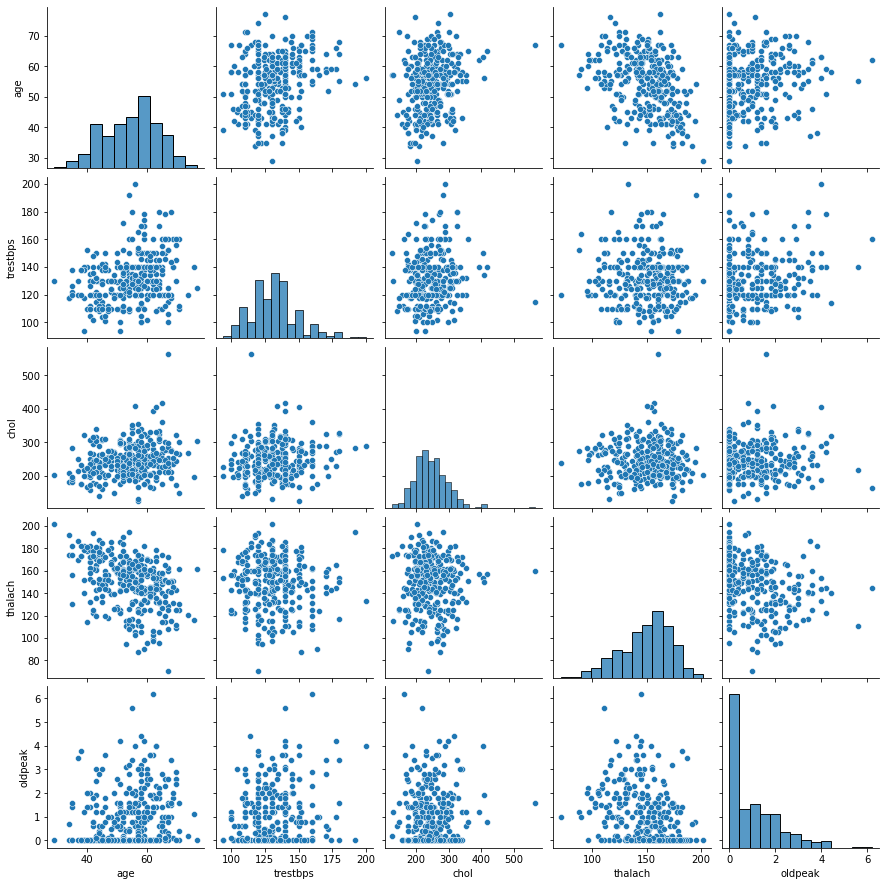

In [353]:
# scatterplot tra le variabili continue e loro distribuzione
col = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
ax = sns.pairplot(df[col])
plt.show()

In [207]:
# one-hot encoding delle variabili categoriali 

df['cp_0'] = df.loc[df[df['cp'] == 0].index,['cp']]
df.loc[df[df['cp_0'].notna()].index,['cp_0']] = 1
df['cp_1'] = df.loc[df[df['cp'] == 1].index,['cp']]
df.loc[df[df['cp_1'].notna()].index,['cp_1']] = 1
df['cp_2'] = df.loc[df[df['cp'] == 2].index,['cp']]
df.loc[df[df['cp_2'].notna()].index,['cp_2']] = 1
df['cp_3'] = df.loc[df[df['cp'] == 3].index,['cp']]
df.loc[df[df['cp_3'].notna()].index,['cp_3']] = 1

df['restecg_0'] = df.loc[df[df['restecg'] == 0].index,['restecg']]
df.loc[df[df['restecg_0'].notna()].index,['restecg_0']] = 1
df['restecg_1'] = df.loc[df[df['restecg'] == 1].index,['restecg']]
df.loc[df[df['restecg_1'].notna()].index,['restecg_1']] = 1
df['restecg_2'] = df.loc[df[df['restecg'] == 2].index,['restecg']]
df.loc[df[df['restecg_2'].notna()].index,['restecg_2']] = 1

df['slope_0'] = df.loc[df[df['slope'] == 0].index,['slope']]
df.loc[df[df['slope_0'].notna()].index,['slope_0']] = 1
df['slope_1'] = df.loc[df[df['slope'] == 1].index,['slope']]
df.loc[df[df['slope_1'].notna()].index,['slope_1']] = 1
df['slope_2'] = df.loc[df[df['slope'] == 2].index,['slope']]
df.loc[df[df['slope_2'].notna()].index,['slope_2']] = 1

df['thal_0'] = df.loc[df[df['thal'] == 0].index,['thal']]
df.loc[df[df['thal_0'].notna()].index,['thal_0']] = 1
df['thal_1'] = df.loc[df[df['thal'] == 1].index,['thal']]
df.loc[df[df['thal_1'].notna()].index,['thal_1']] = 1
df['thal_2'] = df.loc[df[df['thal'] == 2].index,['thal']]
df.loc[df[df['thal_2'].notna()].index,['thal_2']] = 1
df['thal_3'] = df.loc[df[df['thal'] == 3].index,['thal']]
df.loc[df[df['thal_3'].notna()].index,['thal_3']] = 1

df.fillna(0, inplace=True)

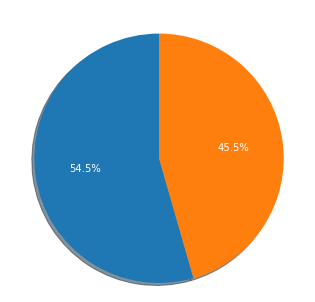

In [208]:
# analisi per capire se la variabile target è già bilanciata o meno

freq_y = df.target.value_counts()
value_y = freq_y.values

fig, ax = plt.subplots(figsize=(5,5)) 
ax.pie(value_y, labels=['Yes', 'No'], autopct='%1.1f%%',
        shadow=True, startangle=90, textprops={'color':"w"})
ax.axis('equal')
ax.set_title('Target', color = 'white')
plt.show()

Analisi delle anomalie

Sono utilizzati due metodi diversi per questo tipo di analisi e, alla fine, sono trovate 4 anomalie totali. Dato il loro numero esiguo esse sono rimosse dal dataset.

In [209]:
# analisi delle anomalie
df1=df.drop(['target'], axis=1)

clf = IsolationForest(max_samples='auto', contamination=0.01)
clf.fit(df1)
df1['Anomaly IF'] = clf.predict(df1)

lf = LocalOutlierFactor(n_neighbors=10)
clf.fit(df1)
df1['Anomaly LOF'] = clf.predict(df1)

In [210]:
# anomalie trovate
anomalies = df1[(df1['Anomaly IF'] == -1) | (df1['Anomaly LOF'] == -1)]
print(len(anomalies))
anomalies

4


age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  ...  \
0     63    1   3       145   233    1        0      150      0      2.3  ...   
266   55    0   0       180   327    0        2      117      1      3.4  ...   
281   52    1   0       128   204    1        1      156      1      1.0  ...   
291   58    1   0       114   318    0        2      140      0      4.4  ...   

     restecg_2  slope_0  slope_1  slope_2  thal_0  thal_1  thal_2  thal_3  \
0          0.0      1.0      0.0      0.0     0.0     1.0     0.0     0.0   
266        1.0      0.0      1.0      0.0     0.0     0.0     1.0     0.0   
281        0.0      0.0      1.0      0.0     1.0     0.0     0.0     0.0   
291        1.0      1.0      0.0      0.0     0.0     1.0     0.0     0.0   

     Anomaly IF  Anomaly LOF  
0            -1           -1  
266          -1           -1  
281          -1           -1  
291          -1           -1  

[4 rows x 29 columns]

In [211]:
# eliminazione dei valori anomali dal dataset
df = df.drop(anomalies.index.values, axis=0)

### Modello 1: SVM

Vengono testati e confrontati 3 modelli differenti per la predizione della variabile target: una Support Vector Machine (SVM), una regressione logistica (LR) e una rete neurale (NN).  
Il dataset è quindi diviso in due subset, uno di training, contenente il 70% dei dati, e uno di test, con il 30% rimanente. Per ogni modello è stampato un report contenente le principali metriche di classificazione e una matrice di confusione. Oltre a queste metriche i modelli sono confrontati attarverso un grafico contenente le rispettive curve ROC ed il calcolo della AUC.

In [212]:
# creazione di un dataset dei predittori e uno della variabile target
variables = list(df.columns)
variables.remove('target')

x = df[variables]
y = df['target']

In [213]:
# train test splitting dei predittori e della variabile target
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

In [214]:
# creazione e fitting del modello
svc = SVC(random_state=0, probability=True)
svc.fit(x_train, y_train)

print(f'Model accuracy: {svc.score(x_test, y_test)}')

# previsioni sui predittori di test
svc_pred = svc.predict(x_test)

Model accuracy: 0.7


In [215]:
# classification report
print(classification_report(y_test, svc_pred))

              precision    recall  f1-score   support

           0       0.79      0.39      0.53        38
           1       0.68      0.92      0.78        52

    accuracy                           0.70        90
   macro avg       0.73      0.66      0.65        90
weighted avg       0.72      0.70      0.67        90



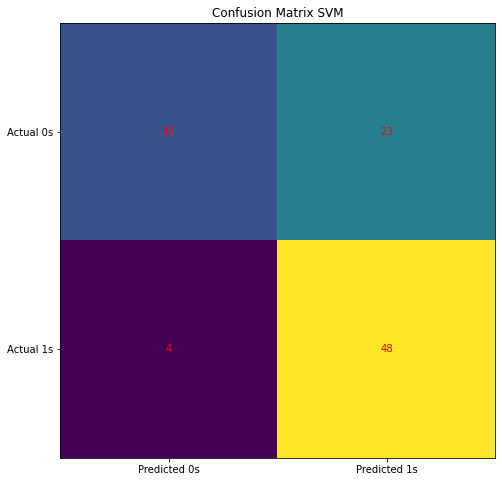

In [216]:
# matrice di confusione 
cm = confusion_matrix(y_test, svc_pred)
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.title("Confusion Matrix SVM")
plt.show()

### Modello 2: Logistic Regression

In [217]:
from sklearn.linear_model import LogisticRegression
# creazione e fitting del modello
lr = LogisticRegression(solver='liblinear', random_state=0, penalty='l1') # penalità l1 per compiere anche feature selection
lr.fit(x_train, y_train)
print(f'Model accuracy: {lr.score(x_test, y_test)}')

# previsioni
lr_pred = lr.predict(x_test)

Model accuracy: 0.8333333333333334


In [218]:
# classification report
print(classification_report(y_test, lr_pred))

              precision    recall  f1-score   support

           0       0.87      0.71      0.78        38
           1       0.81      0.92      0.86        52

    accuracy                           0.83        90
   macro avg       0.84      0.82      0.82        90
weighted avg       0.84      0.83      0.83        90



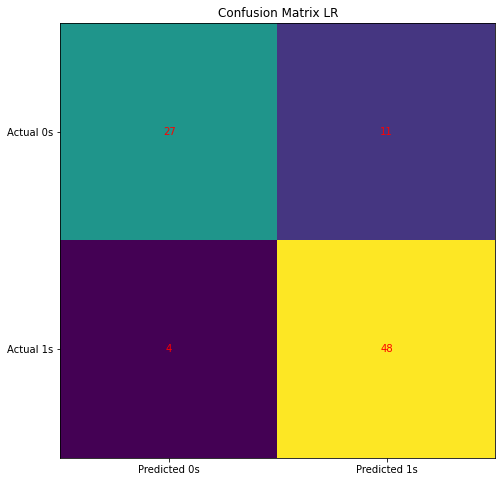

In [219]:
# confusion matrix del modello lr
cm = confusion_matrix(y_test, lr_pred)
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.title("Confusion Matrix LR")
plt.show()

### Modello 3: Neural Network

Prima dell'addestramento della rete neurale le 4 variabili dipendenti con meno correlazione con la variabile target sono rimosse. Questo è empiricamente dimostrabile che aiuti il modello in esame a raggiungere una capacità di classificazione migliore, mentre non sembra influire particolarmente sugli altri due classificatori già trattati.  

La rete in sé è composta da due layer densi di 10 e 5 neuroni ciascuno, da un layer di input, da uno di output e da un piccolo layer di regolarizzazione con un drop-out del 10%.  
Il modello è quindi addestrato e la sua evoluzione nel tempo è mostrata, infine sono prodotte le previsioni per il subset di test e le relative metriche sono visualizzate.

In [220]:
# vengono rimosse le variabili con meno correlazione al target, empiricamente aumenta le performance della NN
x_train_rm = x_train.copy(deep=True)

x_train_rm.drop('fbs', axis=1, inplace=True)
x_train_rm.drop('trestbps', axis=1, inplace=True)
x_train_rm.drop('chol', axis=1, inplace=True)
x_train_rm.drop('restecg', axis=1, inplace=True)

x_test_rm = x_test.copy(deep=True)

x_test_rm.drop('fbs', axis=1, inplace=True)
x_test_rm.drop('trestbps', axis=1, inplace=True)
x_test_rm.drop('chol', axis=1, inplace=True)
x_test_rm.drop('restecg', axis=1, inplace=True)

In [221]:
# definizione del modello

input_shape = x_train_rm.values.shape[1]

model = keras.Sequential (
    [
        keras.Input(shape = (input_shape)),
        layers.Dense(10, activation = "relu"),
        layers.Dense(5, activation = "relu"),
        layers.Dropout(0.1),
        layers.Dense(1, activation='sigmoid')
    ]
)

model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 10)                240       
_________________________________________________________________
dense_31 (Dense)             (None, 5)                 55        
_________________________________________________________________
dropout_10 (Dropout)         (None, 5)                 0         
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 6         
Total params: 301
Trainable params: 301
Non-trainable params: 0
_________________________________________________________________


In [222]:
# addestarmento del modello

batch_size = 10

model.compile(loss= "binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience = 10) # early stopping

history = model.fit(x_train_rm.values, np.array(y_train),
                    epochs=1000, batch_size=batch_size,
                    validation_split = 0.3,
                    callbacks=[es],
                    verbose=0)

stopped = es.stopped_epoch

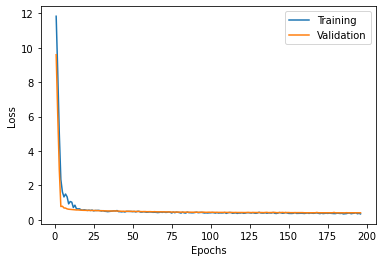

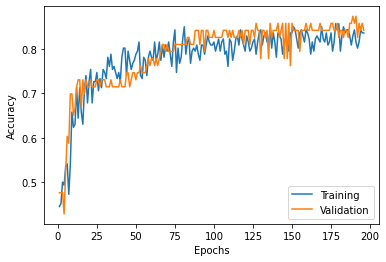

In [223]:
# evoluzione della funzione di loss e di accuracy del training e della validazione

x_plot = list(range(1,stopped+2))

def plot_history(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(x_plot, network_history.history['loss'])
    plt.plot(x_plot, network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(x_plot, network_history.history['accuracy'])
    plt.plot(x_plot, network_history.history['val_accuracy'])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()


plot_history(history)

In [224]:
# previsioni sul dataset di test
proba_nn = model.predict(x_test_rm, batch_size = batch_size) # probabilità

# passaggio da probabilità a one-hot encoding
predict = model.predict(x_test_rm, batch_size = batch_size)
predict[predict <= 0.5] = 0.
predict[predict > 0.5] = 1.

In [225]:
# scoring del modello
score = model.evaluate(x_test_rm, y_test, verbose=0)
print("test loss:", score[0])
print("test accuracy:", score[1])

test loss: 0.37482404708862305
test accuracy: 0.8222222328186035


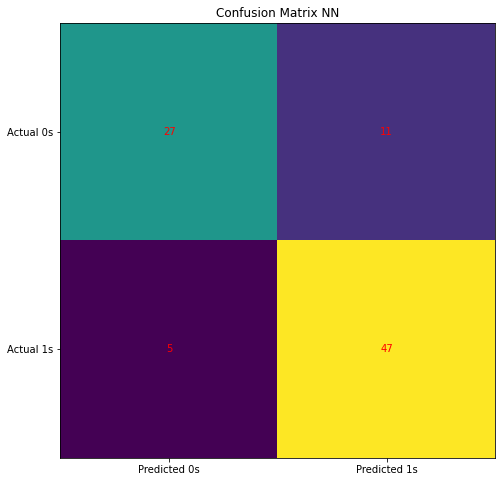

In [226]:
# matrice di confusione 
cm = confusion_matrix(y_test, predict)
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.title("Confusion Matrix NN")
plt.show()

### Confronto tra i modelli

Dopo aver studiato le metriche specifiche per ogni singolo modello si passa ad un confronto tra i tre.  
Viene quindi visualizzato un grafico contenente tutte le curve ROC ed è calcolata la AUC di ogni modello. Osservando i dati a disposizione sembra che la rete neurale e la regressione logistica siano i modelli che performano meglio e, tra loro, quasi alla pari.

In [227]:
# calcolo delle probabilità di appartenenza ad una classe per le osservazioni target
proba_lr = lr.predict_log_proba(x_test)
proba_svc = svc.predict_proba(x_test)

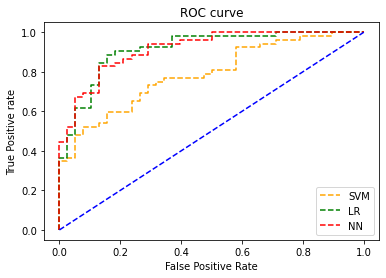

SVC AUC: 0.787
LR AUC: 0.913
NN AUC: 0.915


In [254]:
# creazione della curva ROC per i modelli 
fpr1, tpr1, thresh1 = roc_curve(y_test, proba_svc[:,1], pos_label=1)
fpr2, tpr2, thresh2 = roc_curve(y_test, proba_lr[:,1], pos_label=1)
fpr3, tpr3, thresh3 = roc_curve(y_test, proba_nn, pos_label=1)

# roc per il classificatore casuale
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

# plot roc
plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='SVM')
plt.plot(fpr2, tpr2, linestyle='--',color='green', label='LR')
plt.plot(fpr3, tpr3, linestyle='--',color='red', label='NN')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.show()

roc_auc_svc = auc(fpr1, tpr1)
roc_auc_lr = auc(fpr2, tpr2)
roc_auc_nn = auc(fpr3, tpr3)
print(f'SVC AUC: {roc_auc_svc:.3f}')
print(f'LR AUC: {roc_auc_lr:.3f}')
print(f'NN AUC: {roc_auc_nn:.3f}')

### PCA

Dato l'elevato numero di variabili dipendenti nel dataset, in particolare dopo la binarizzazione delle variabili categoriche, un'analisi delle componenti principali è implementata per cercare di migliorare le performance dei modelli. Un veloce studio dello screeplot per le prime 10 componenti evidenzia come la maggior parte della varianza sia racchiusa dalle prime 4 di esse.  
A questo punto il dataset di training è utilizzato per il fit delle 4 componenti prese in esame e, poi, queste sono adoperate per trasformare il dataset di test; i nuovi subset sono quindi analizzati seguendo le stesse proceure di cui sopra e i risultati ottenuti sono di seguito commentati.

In [257]:
from sklearn.decomposition import PCA

# creazione e fit delle componenti
pca = PCA(n_components=10)
fit = pca.fit(x_train)

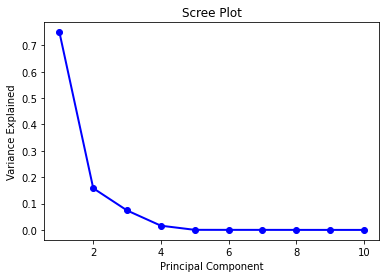

In [258]:
# scree plot delle prime 10 componenti
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

In [259]:
# scelta delle prime 4 componenti principali
pca = PCA(n_components=4)
x_train_pca = pca.fit_transform(x_train)
x_test_pca = pca.transform(x_test)

Addestramento e previsioni con le pca

In [260]:
# modello svc sulle pc
svc.fit(x_train_pca, y_train)
svc_pred_pca = svc.predict(x_test_pca)
print(f'Model accuracy: {svc.score(x_test_pca, y_test)}')

# classification report
print(classification_report(y_test, svc_pred_pca))

Model accuracy: 0.6555555555555556
              precision    recall  f1-score   support

           0       0.61      0.53      0.56        38
           1       0.68      0.75      0.72        52

    accuracy                           0.66        90
   macro avg       0.65      0.64      0.64        90
weighted avg       0.65      0.66      0.65        90



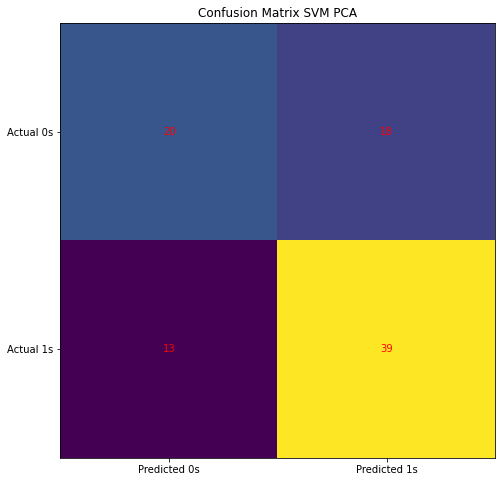

In [261]:
# confusion matrix
cm = confusion_matrix(y_test, svc_pred_pca)
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.title("Confusion Matrix SVM PCA")
plt.show()

In [262]:
# modello lr sulle pc
lr.fit(x_train_pca, y_train)
lr_pred_pca = lr.predict(x_test_pca)
print(f'Model accuracy: {lr.score(x_test_pca, y_test)}')

# classification report
print(classification_report(y_test, lr_pred_pca))

Model accuracy: 0.7222222222222222
              precision    recall  f1-score   support

           0       0.67      0.68      0.68        38
           1       0.76      0.75      0.76        52

    accuracy                           0.72        90
   macro avg       0.72      0.72      0.72        90
weighted avg       0.72      0.72      0.72        90



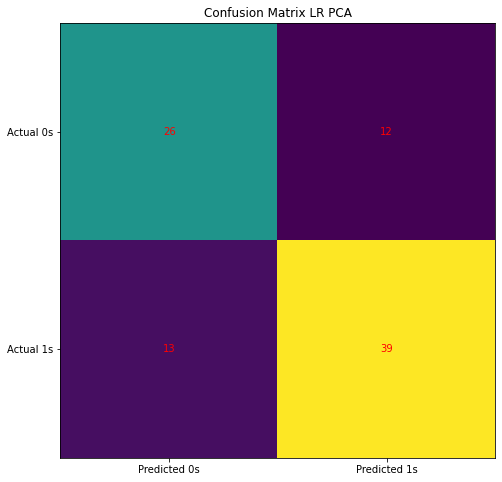

In [263]:
# confusion matrix del modello lr

cm = confusion_matrix(y_test, lr_pred_pca)
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.title("Confusion Matrix LR PCA")
plt.show()

In [264]:
# definizione del modello

input_shape = x_train_pca.shape[1]

model_pca = keras.Sequential (
    [
        keras.Input(shape = (input_shape)),
        layers.Dense(10, activation = "relu"),
        layers.Dense(5, activation = "relu"),
        layers.Dropout(0.1),
        layers.Dense(1, activation='sigmoid')
    ]
)

model_pca.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_33 (Dense)             (None, 10)                50        
_________________________________________________________________
dense_34 (Dense)             (None, 5)                 55        
_________________________________________________________________
dropout_11 (Dropout)         (None, 5)                 0         
_________________________________________________________________
dense_35 (Dense)             (None, 1)                 6         
Total params: 111
Trainable params: 111
Non-trainable params: 0
_________________________________________________________________


In [265]:
# addestarmento del modello
model_pca.compile(loss= "binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])
history_pca = model_pca.fit(x_train_pca, np.array(y_train),
                    epochs=1000, batch_size=batch_size,
                    validation_split = 0.3,
                    callbacks=[es],
                    verbose=0)

stopped = es.stopped_epoch

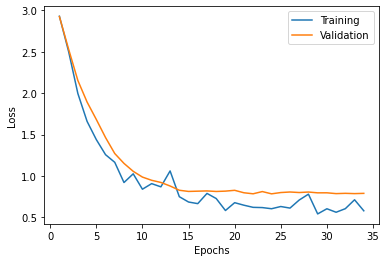

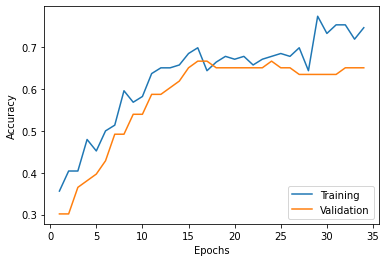

In [266]:
# evoluzione della funzione di loss e di accuracy del training e della validazione

x_plot = list(range(1,stopped+2))

def plot_history(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(x_plot, network_history.history['loss'])
    plt.plot(x_plot, network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(x_plot, network_history.history['accuracy'])
    plt.plot(x_plot, network_history.history['val_accuracy'])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()


plot_history(history_pca)

In [267]:
# previsioni sul dataset di test
proba_nn_pca = model_pca.predict(x_test_pca, batch_size = batch_size) # probabilità

# passaggio da probabilità a one-hot encoding
predict_pca = model_pca.predict(x_test_pca, batch_size = batch_size)
predict_pca[predict_pca <= 0.5] = 0.
predict_pca[predict_pca > 0.5] = 1.

In [268]:
# scoring del modello
score = model_pca.evaluate(x_test_pca, y_test, verbose=0)
print("test loss:", score[0])
print("test accuracy:", score[1])

test loss: 0.7173330783843994
test accuracy: 0.6111111044883728


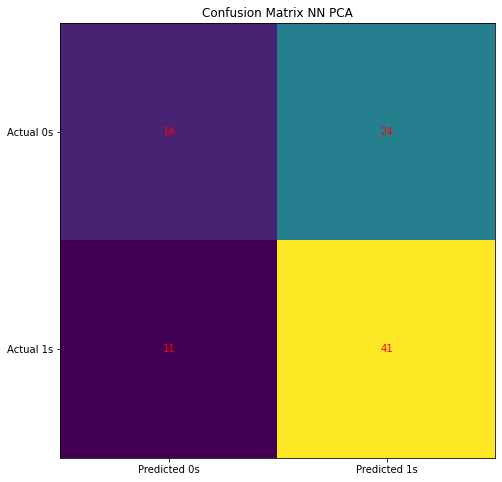

In [269]:
# matrice di confusione NN sulle PCA
cm = confusion_matrix(y_test, predict_pca)
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.title("Confusion Matrix NN PCA")
plt.show()

In [270]:
# calcolo delle probabilità di appartenenza ad una classe per le osservazioni target
proba_lr_pca = lr.predict_log_proba(x_test_pca)
proba_svc_pca = svc.predict_proba(x_test_pca)

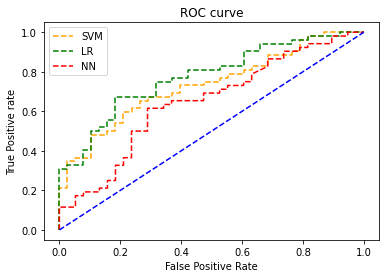

SVC AUC: 0.733
LR AUC: 0.776
NN AUC: 0.647


In [271]:
# creazione della curva ROC per i modelli 

fpr1, tpr1, thresh1 = roc_curve(y_test, proba_svc_pca[:,1], pos_label=1)
fpr2, tpr2, thresh2 = roc_curve(y_test, proba_lr_pca[:,1], pos_label=1)
fpr3, tpr3, thresh3 = roc_curve(y_test, proba_nn_pca, pos_label=1)

# roc per il classificatore casuale
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

# plot roc
plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='SVM')
plt.plot(fpr2, tpr2, linestyle='--',color='green', label='LR')
plt.plot(fpr3, tpr3, linestyle='--',color='red', label='NN')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.show()

roc_auc_svc = auc(fpr1, tpr1)
roc_auc_lr = auc(fpr2, tpr2)
roc_auc_nn = auc(fpr3, tpr3)
print(f'SVC AUC: {roc_auc_svc:.3f}')
print(f'LR AUC: {roc_auc_lr:.3f}')
print(f'NN AUC: {roc_auc_nn:.3f}')

Al contrario delle apettative l'utilizzo delle componenti principali riduce notevolmente le performance dei modelli in esame.